In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
3
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
check_path = os.path.join(strategy_path, 'check')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from EMDY import EMDY
from EMPE import EMPE
from EMPM import EMPM
from EMSS import EMSS
from EMCA import EMCA

In [5]:
# EM equity data
emindex = pd.read_csv(os.path.join(data_path, 'totindex-em.csv'), header=0, index_col=0, parse_dates=True)
emindex1 = pd.read_csv(os.path.join(data_path, 'priceindex-em.csv'), header=0, index_col=0, parse_dates=True)
emfut = pd.read_csv(os.path.join(data_path, 'fut1return-em.CSV'), header=0, index_col=0, parse_dates=True)

total_em_ret = emindex.pct_change()
prc_em_ret = emindex1.pct_change()
fut_em_ret = emfut.pct_change()
fut_em_ret = fut_em_ret.reindex(pd.date_range(fut_em_ret.index[0], fut_em_ret.index[-1], freq ='B')) # bizday로 변환

prc_em_ret.loc[total_em_ret.index] = total_em_ret
raw_index = pd.concat([emindex1.loc[:'2012-12-31'], emfut.loc['2013-01-01':]]).iloc[1:]
EMRet = pd.concat([prc_em_ret.loc[:'2012-12-31'], fut_em_ret.loc['2013-01-01':]]).iloc[1:]

EMRet.fillna(0, inplace = True)
EMindex = EMRet
EMindex.iloc[0] = 0
EMindex = (1+ EMindex).cumprod()
EMindex = EMindex / EMindex.iloc[0]

raw_index.index.name = 'tdate'
raw_index.columns.name = 'ticker'

EMindex.index.name = 'tdate'
EMRet.index.name = 'tdate'

EMindex.columns.name = 'ticker'
EMRet.columns.name = 'ticker'

raw_index = pd.read_csv(os.path.join(data_path,'priceindex-mon-em.csv') ,header=0, index_col=0, parse_dates=True)
raw_index.index.name = 'tdate'
raw_index.columns.name = 'ticker'

In [6]:
start_date = '2004'
end_date = '2018'

In [7]:
%matplotlib inline

## 1. EMDY

In [8]:
emdy = EMDY(strategy_name="EMDY", asset_type="EMERGING")
emdy.load_index_and_return(from_db=True, save_file=True)

2020-02-04 08:56:45,726 - EMDY - INFO - [STEP 0] START LOGGING EMDY
2020-02-04 08:56:45,729 - EMDY - INFO - [STEP 1] LOAD DATA
2020-02-04 08:56:45,730 - EMDY - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 08:56:45,740 - EMDY - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 08:56:48,420 - EMDY - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 08:56:51,116 - EMDY - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 08:57:08,466 - EMDY - INFO - [STEP 1 - 4] MERGE BLOOM AND PAST DATA
2020-02-04 08:57:08,476 - EMDY - INFO - [STEP 1 - 5] SAVE RETURN DATA INTO CSV FORMAT


In [9]:
emdy.raw_index = emdy.index * emindex1.reindex(emdy.raw_index.index).iloc[0]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



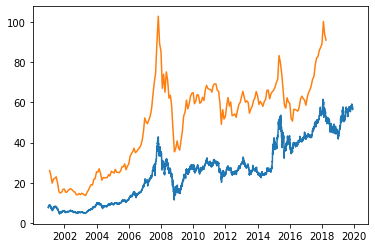

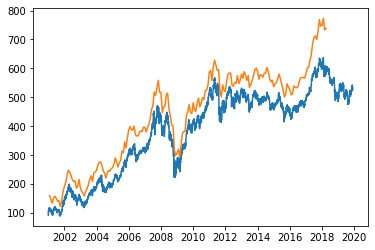

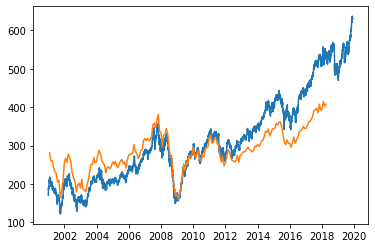

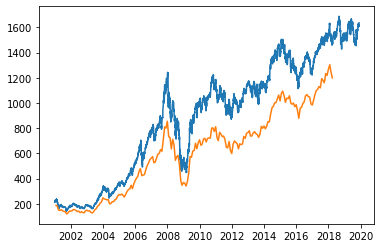

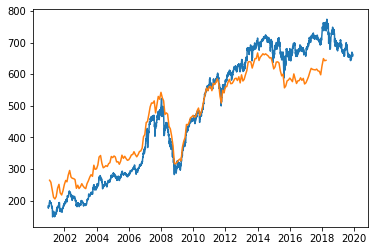

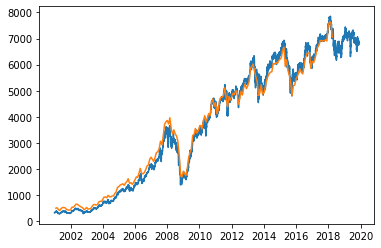

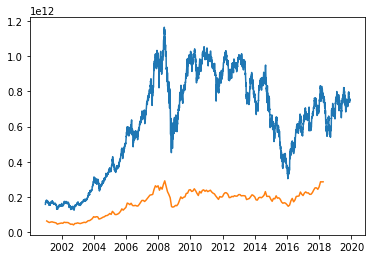

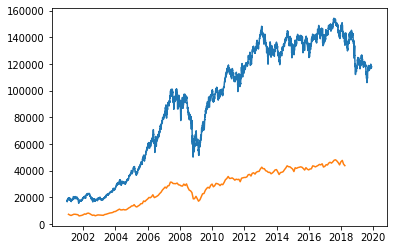

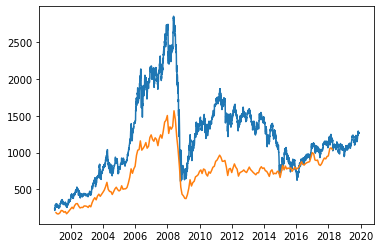

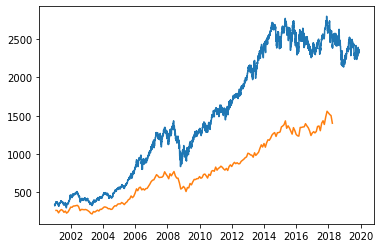

In [10]:
for column in raw_index.columns:
    plt.plot((emdy.raw_index.loc['2001':][[column]]))
    plt.plot((raw_index.loc['2001':][[column]]))
    plt.show()

In [11]:
emdy.load_strategy_data1(table='DS', origin1='DPS-em', origin2='DPS1-em')
emdy.load_strategy_data2(table='bloom', origin='10Yield-em')
emdy.set_rebalance_period(ts_freq='month', cs_freq='month')

2020-02-04 08:57:14,401 - EMDY - INFO - [STEP 2] SET REBALANCE PERIOD


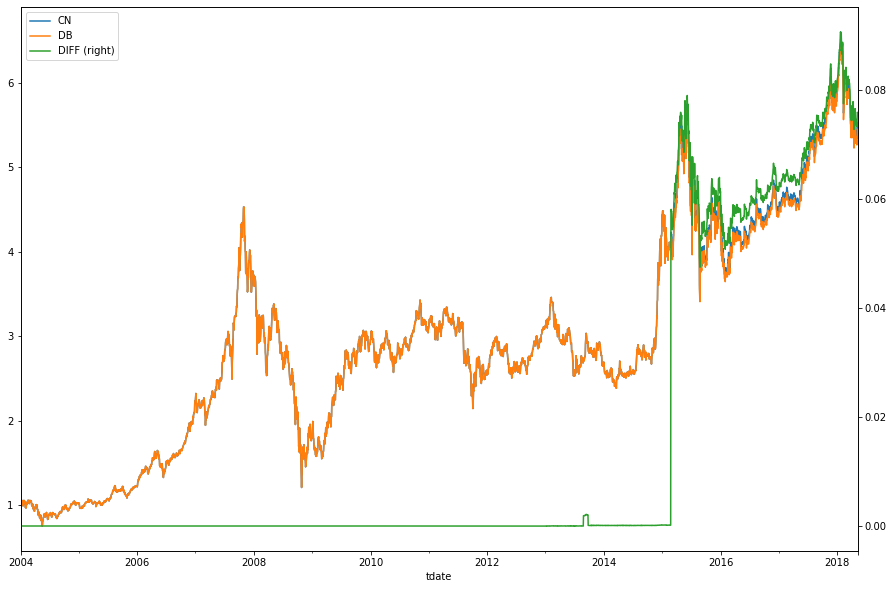

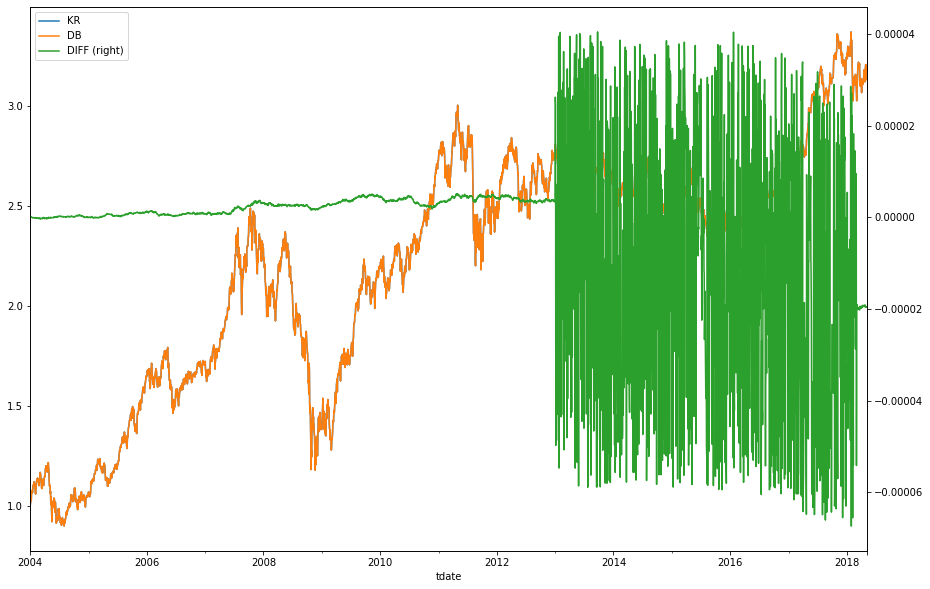

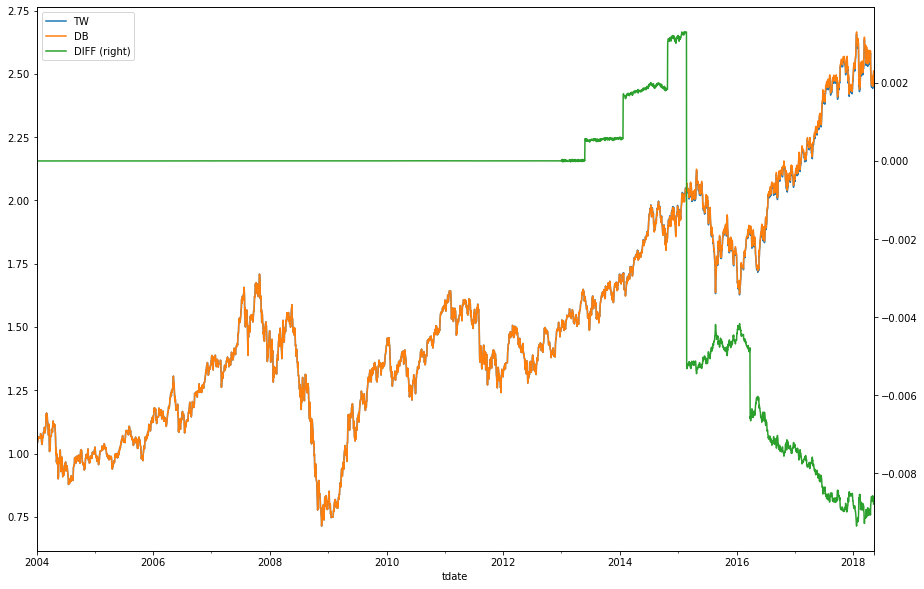

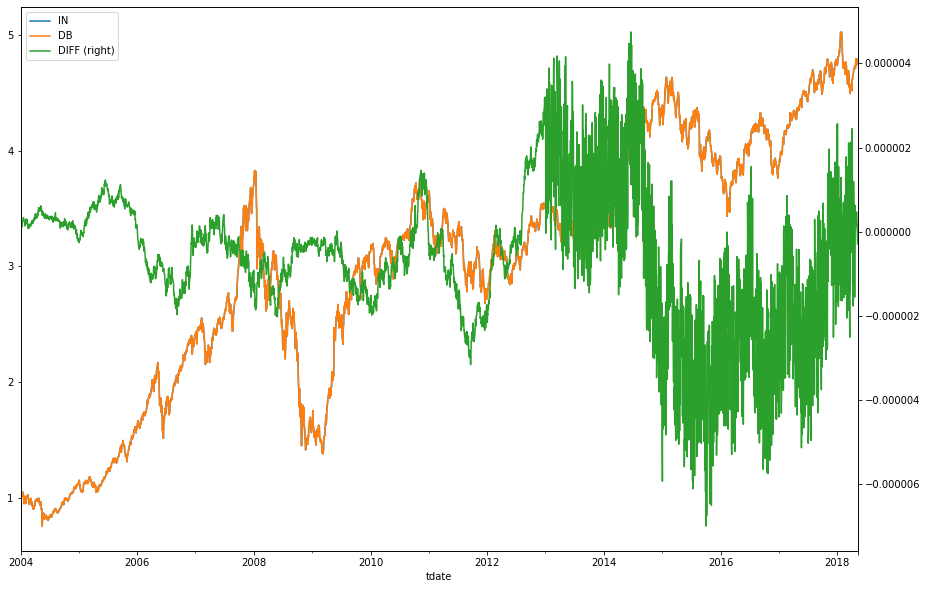

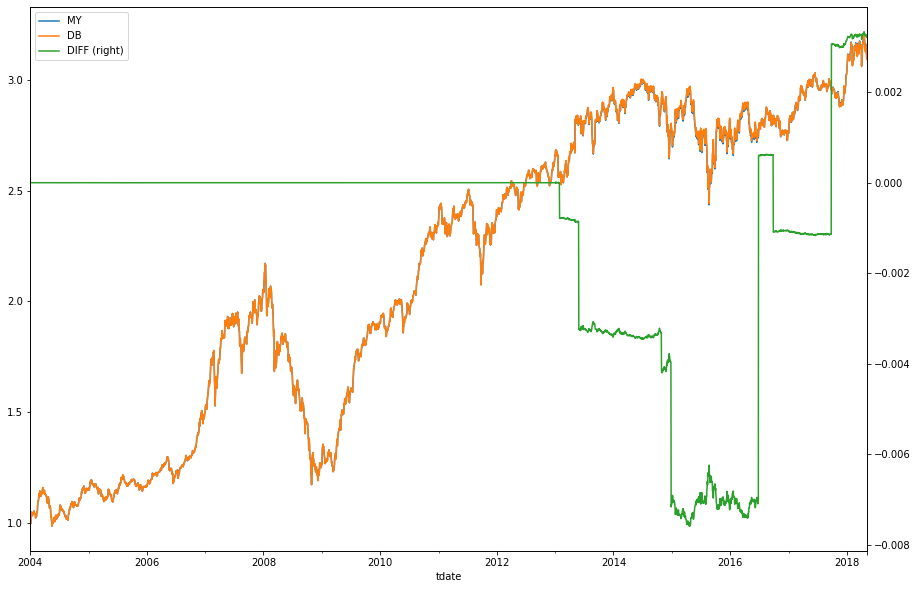

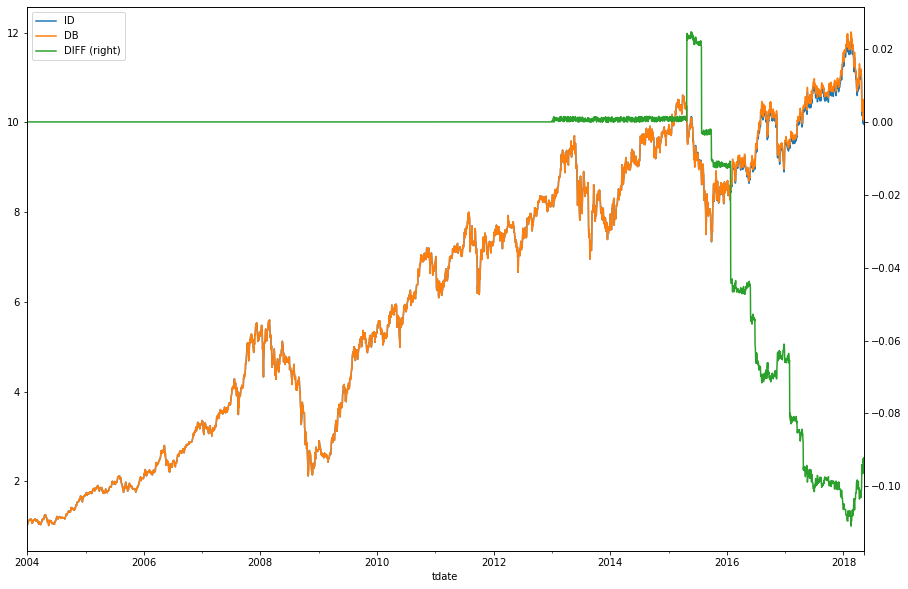

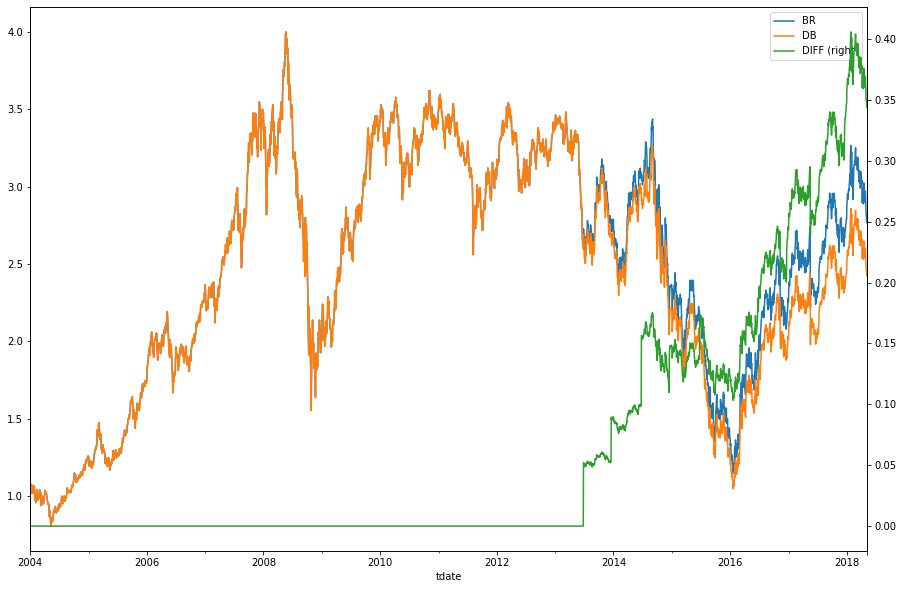

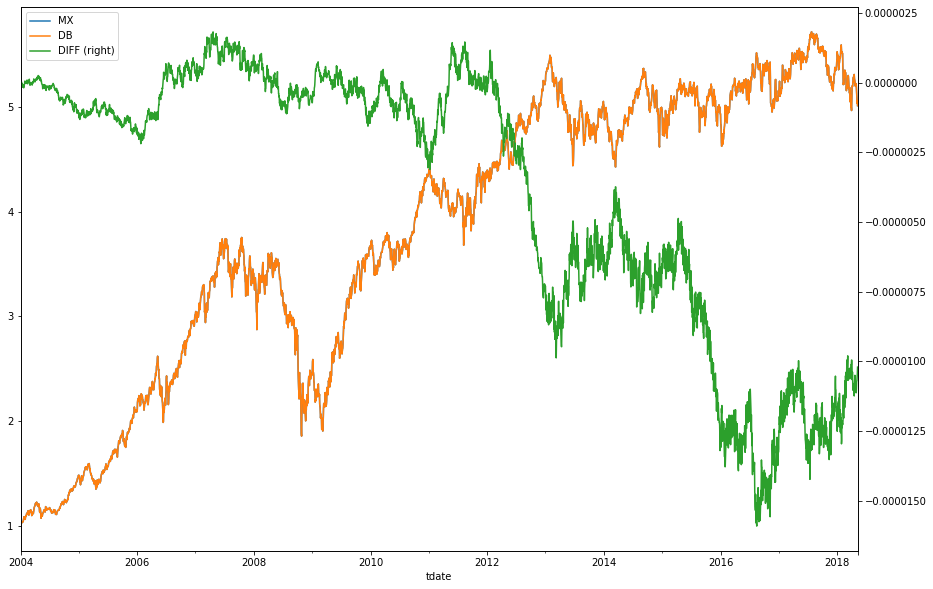

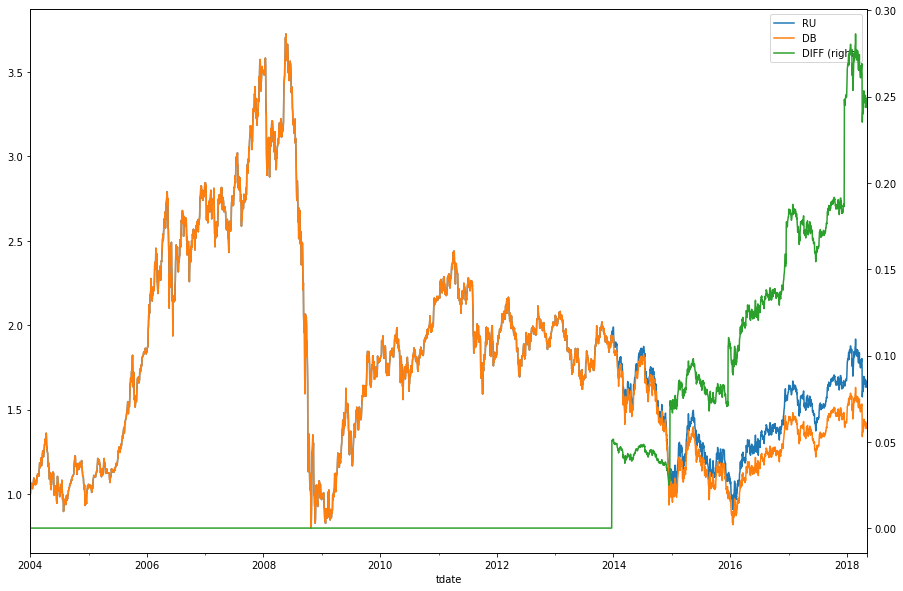

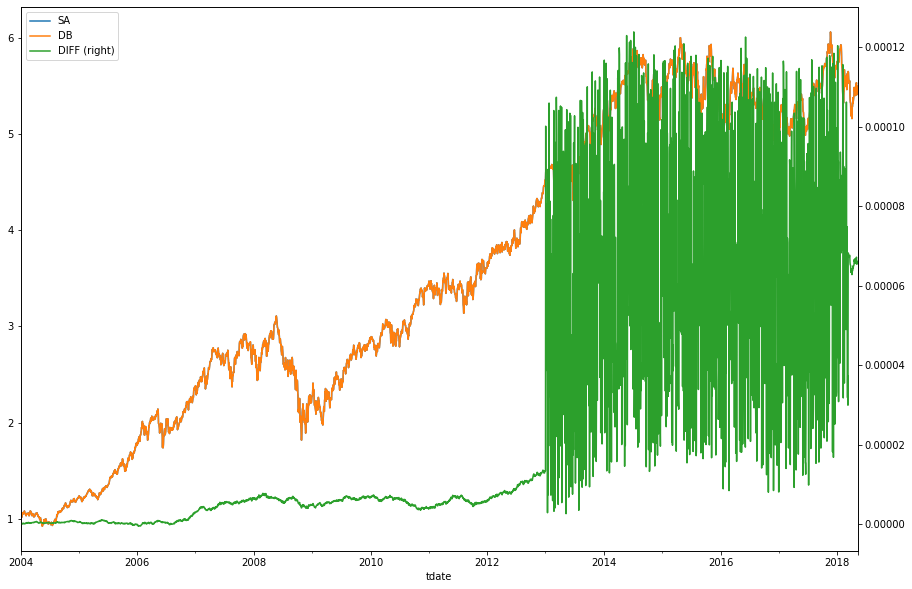

In [12]:
r_data = (1.+ EMRet.loc[start_date:end_date]).cumprod()
db_data = (1.+ emdy.ret.loc[start_date:end_date]).cumprod()

for column in EMindex.columns:
    toplot = r_data[column].to_frame()
    toplot['DB'] = db_data[column]
    toplot['DIFF'] = toplot[column] - toplot['DB']
    toplot.plot(figsize=(15,10), secondary_y='DIFF')

- EM도 조금 차이가 난다.

In [13]:
DPS = pd.read_csv(os.path.join(data_path,'DPS-em.csv') ,header=0, index_col=0, parse_dates=True)
DPS1 = pd.read_csv(os.path.join(data_path,'DPS1-em.csv') ,header=0, index_col=0, parse_dates=True)
yield_ = pd.read_csv(os.path.join(data_path,'10Yield-em.csv') ,header=0, index_col=0, parse_dates=True)

### DPS 차이

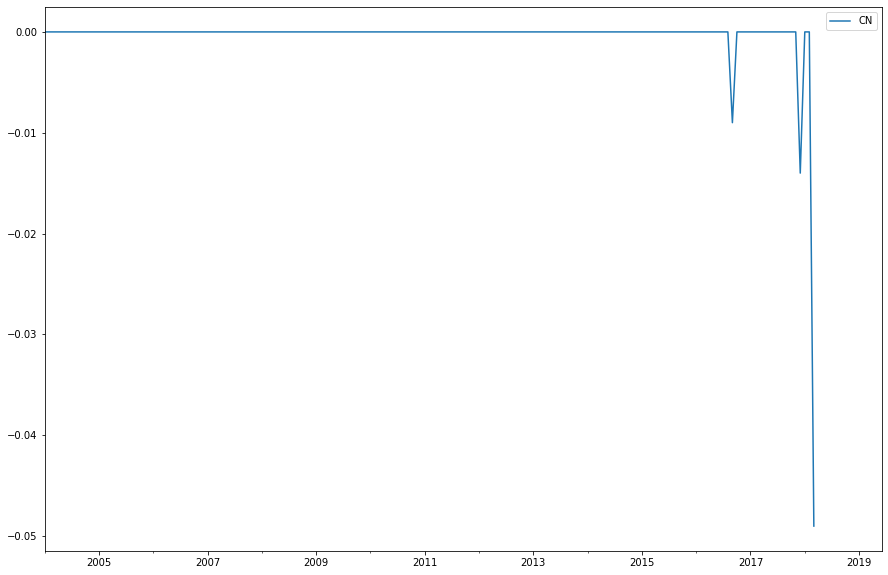

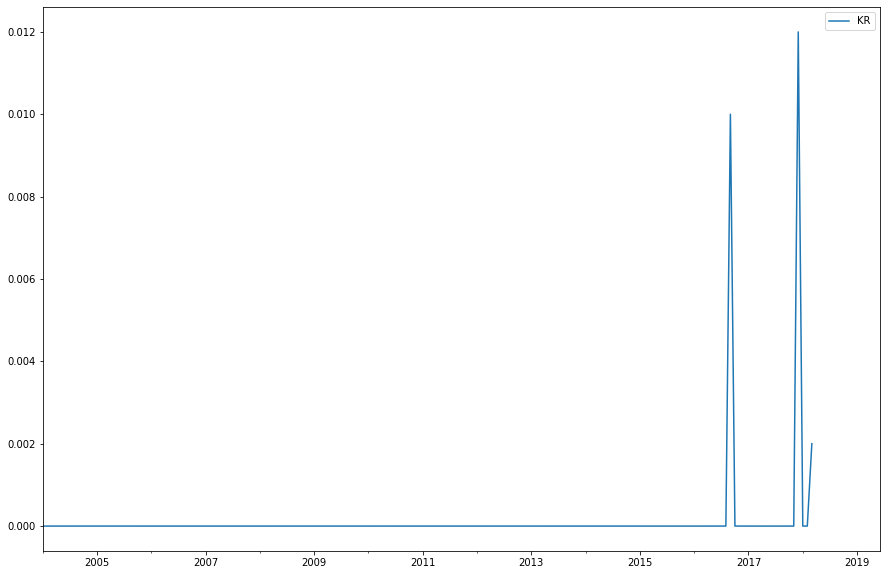

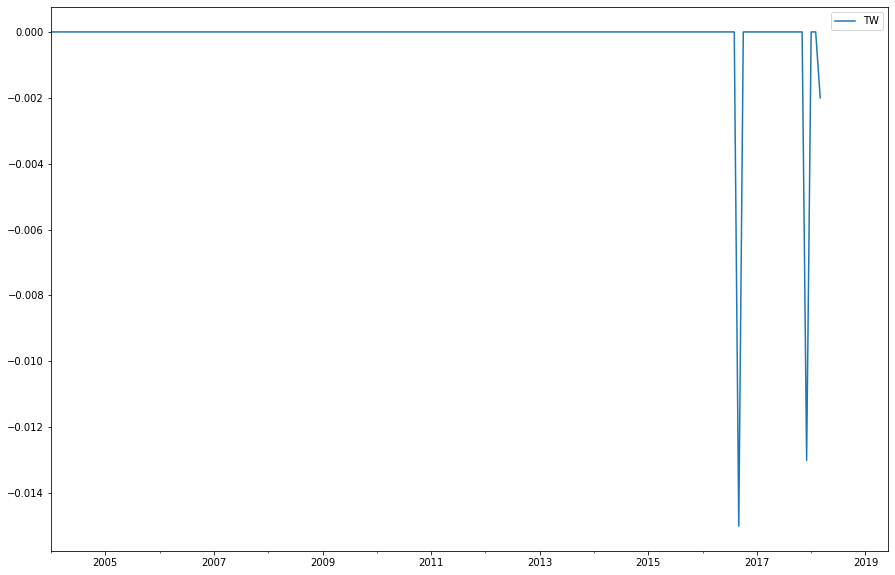

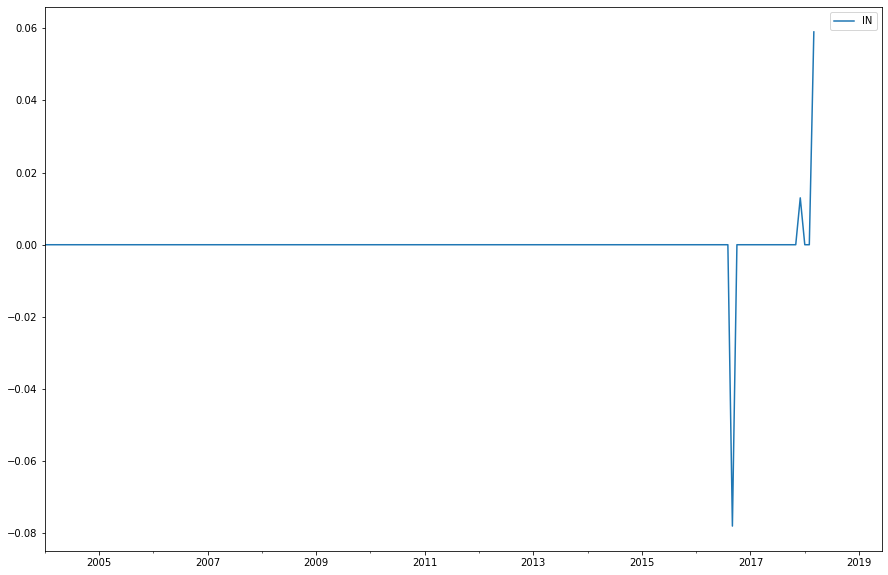

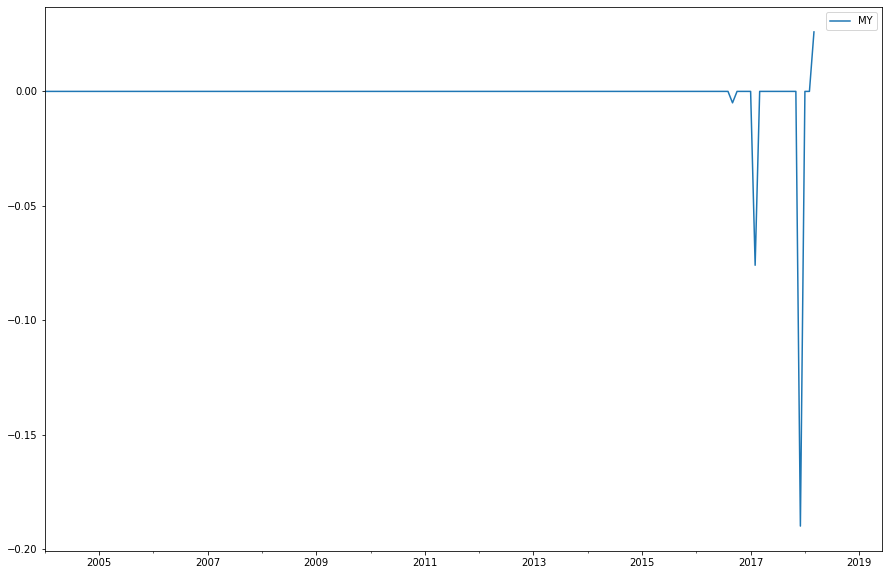

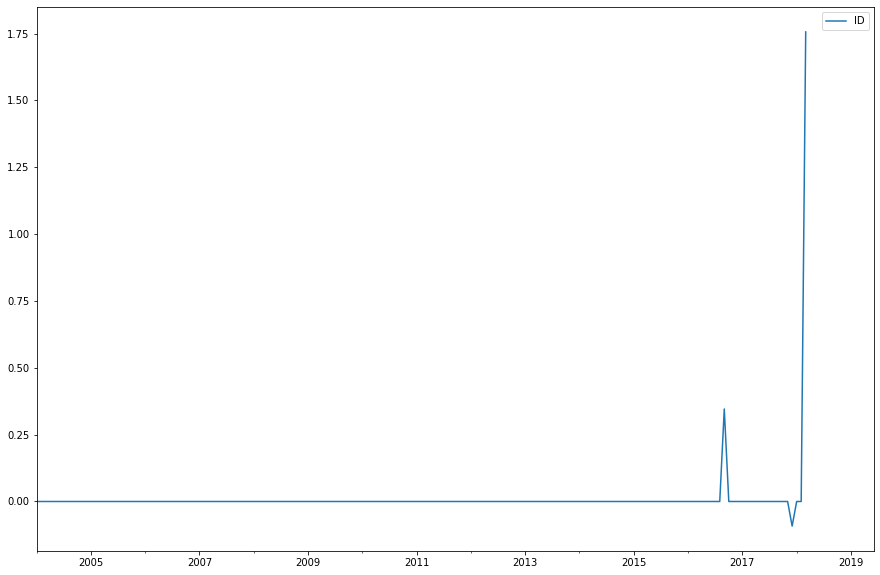

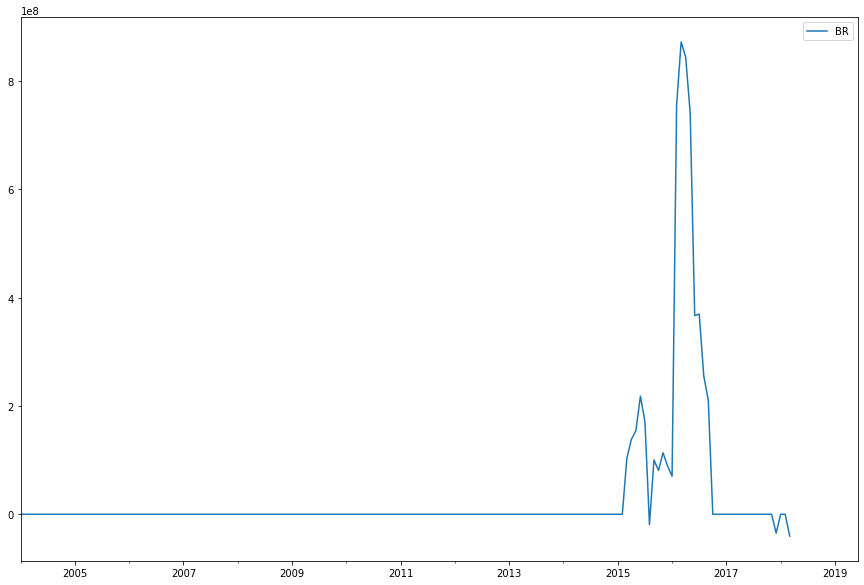

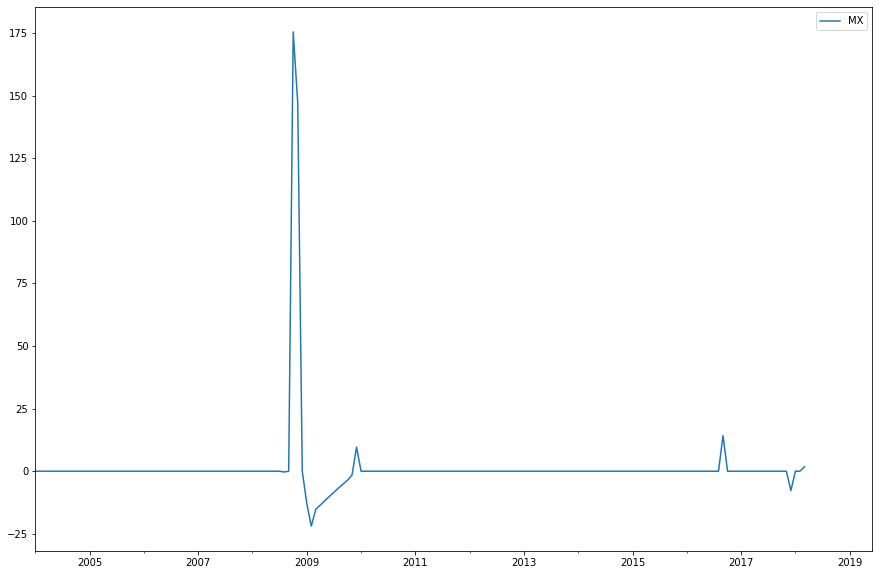

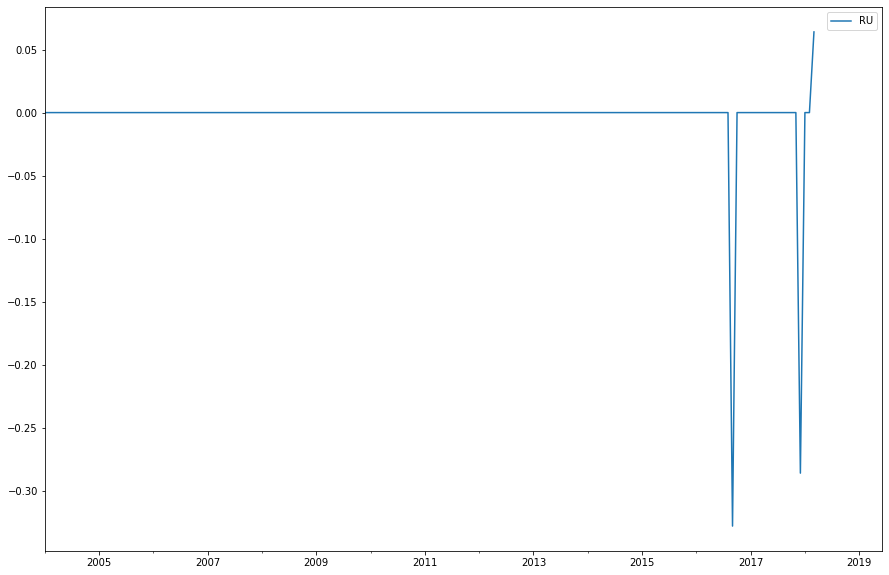

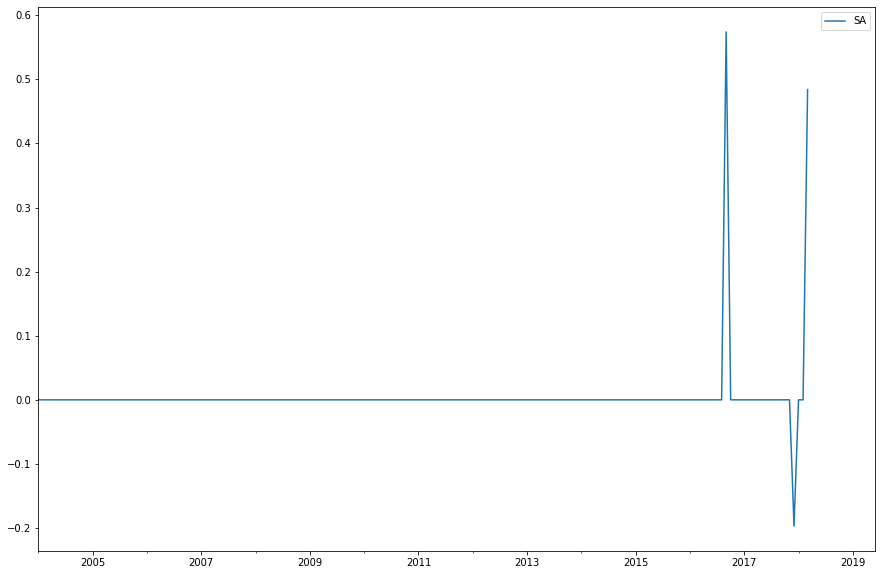

In [14]:
for column in DPS.columns:
    (DPS - emdy.dps.reindex(emdy.dps.index))[[column]].loc['2004':].plot(figsize=(15,10))
    plt.legend()
    plt.plot()

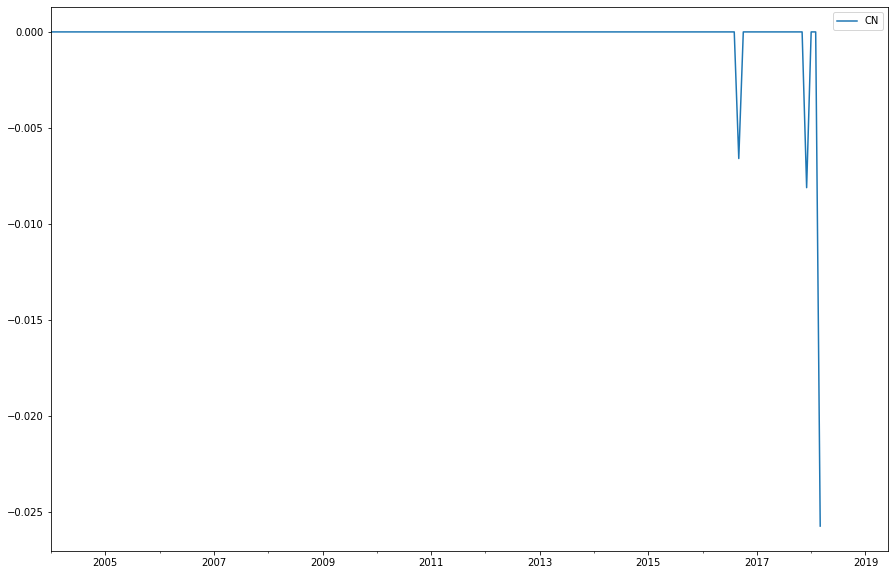

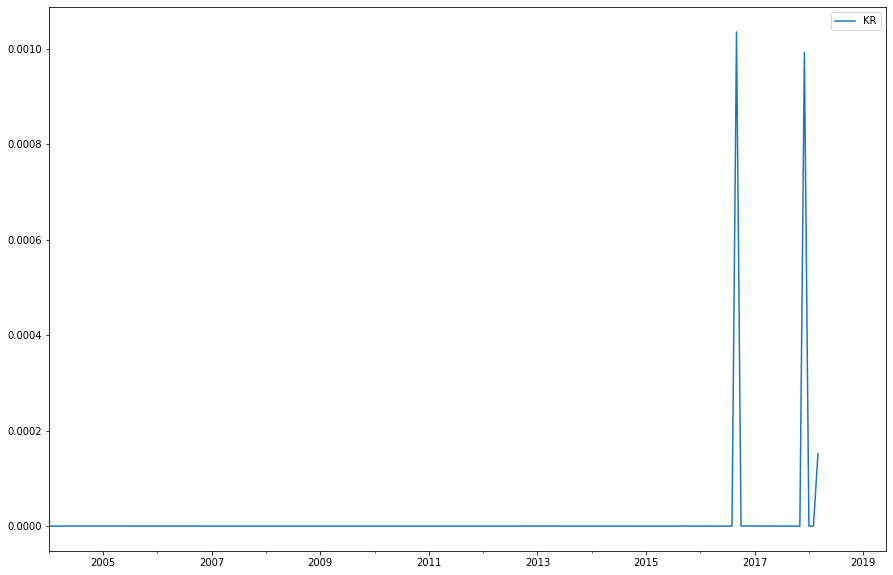

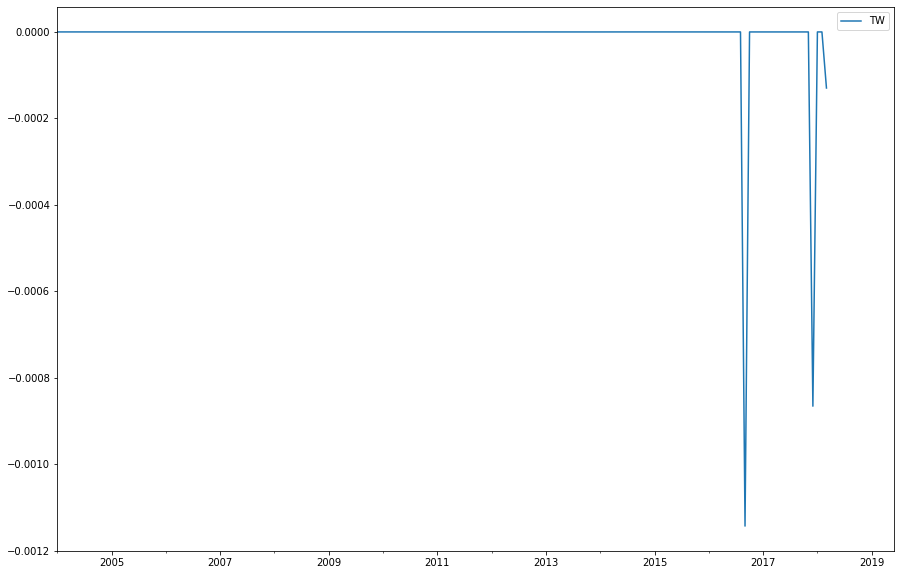

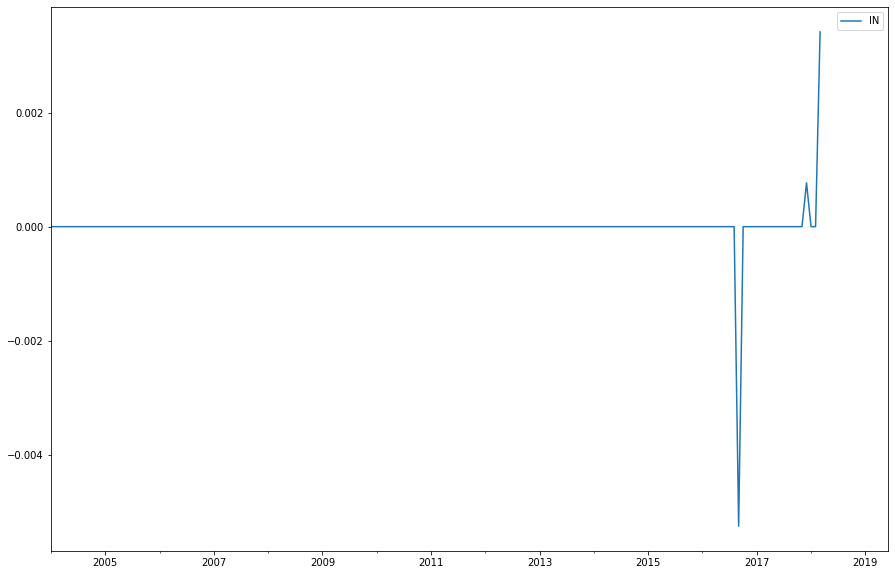

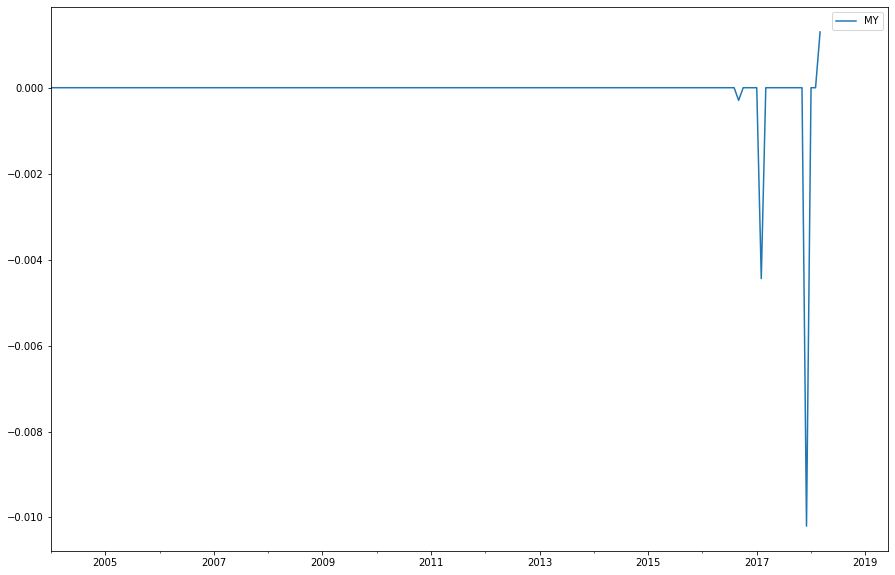

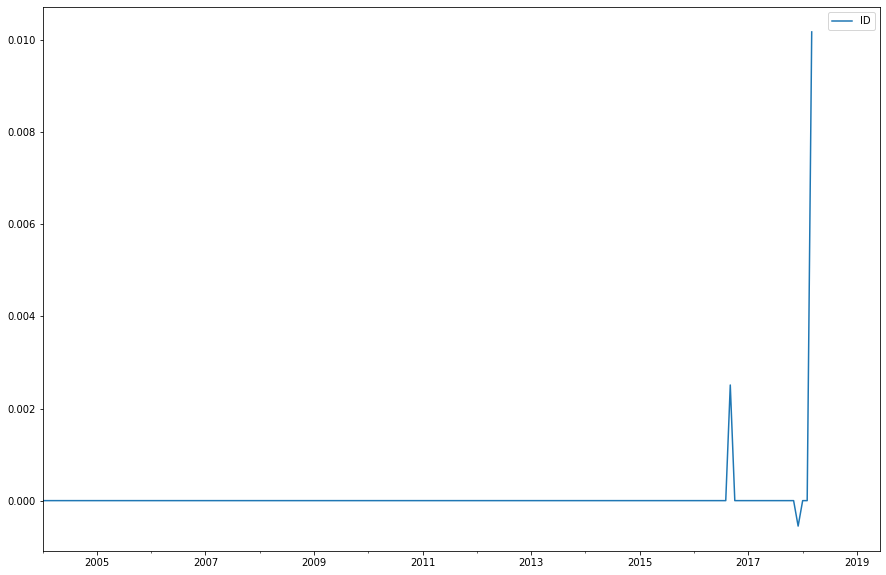

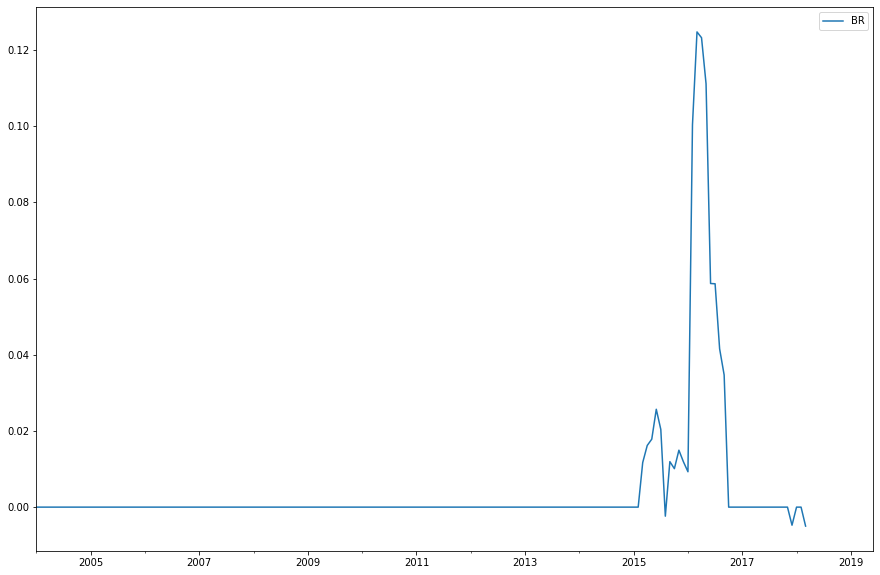

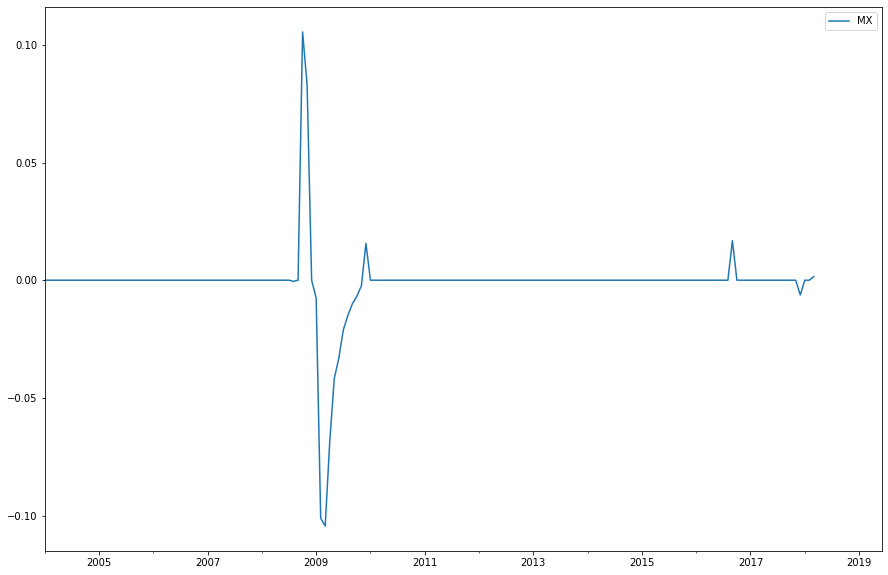

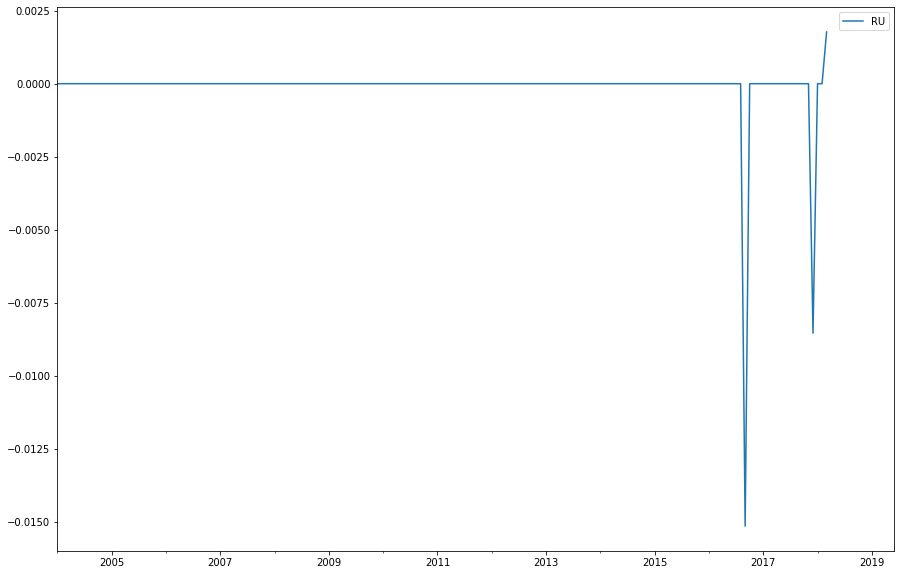

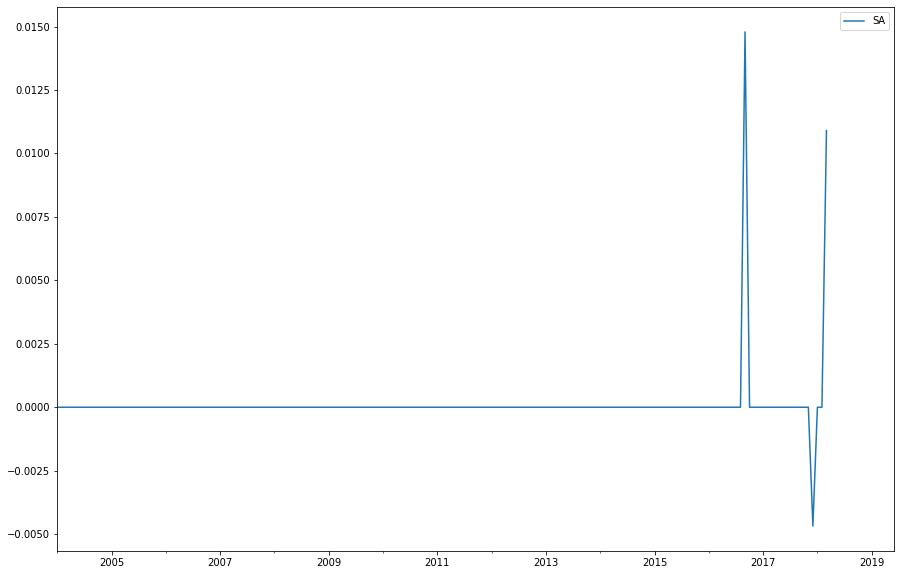

In [15]:
for column in DPS.columns:
    ((DPS - emdy.dps.reindex(emdy.dps.index))/DPS)[[column]].loc['2004':].plot(figsize=(15,10))
    plt.legend()
    plt.plot()

### DPS1 차이

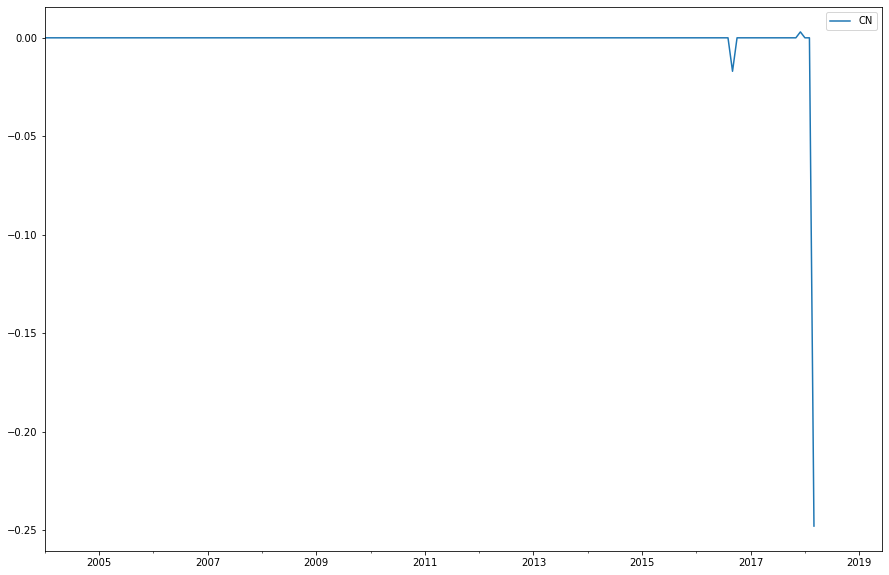

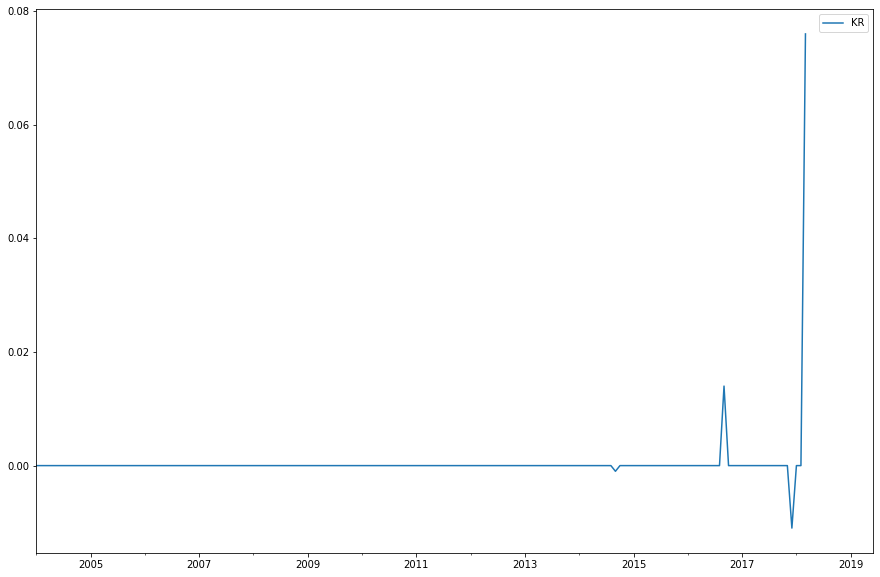

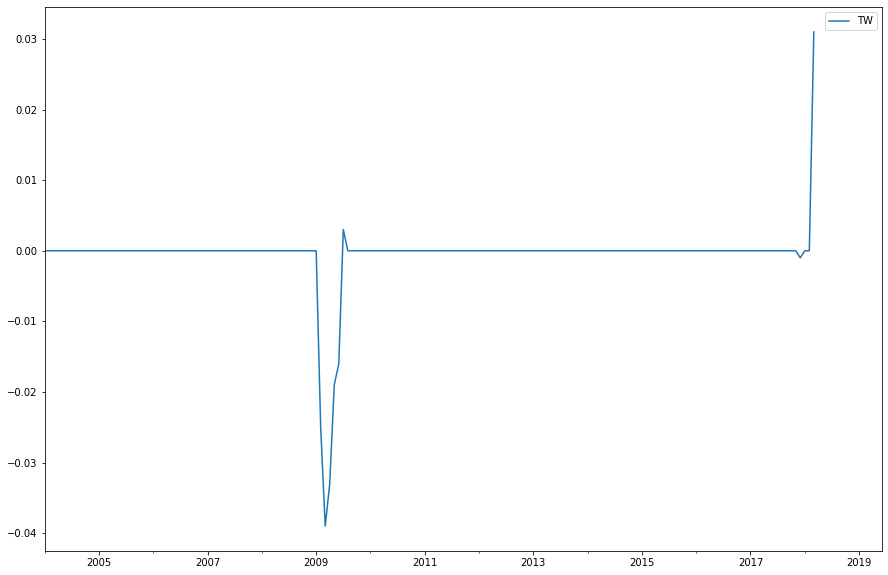

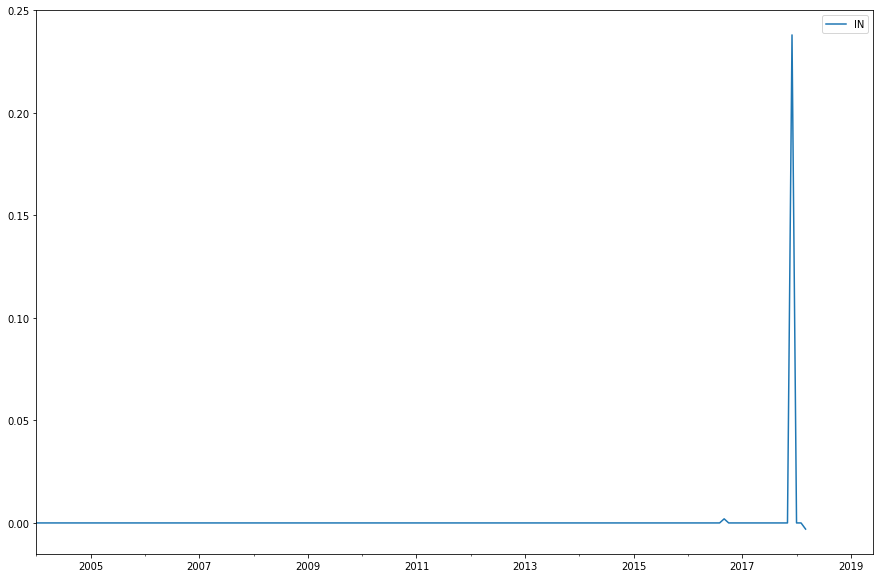

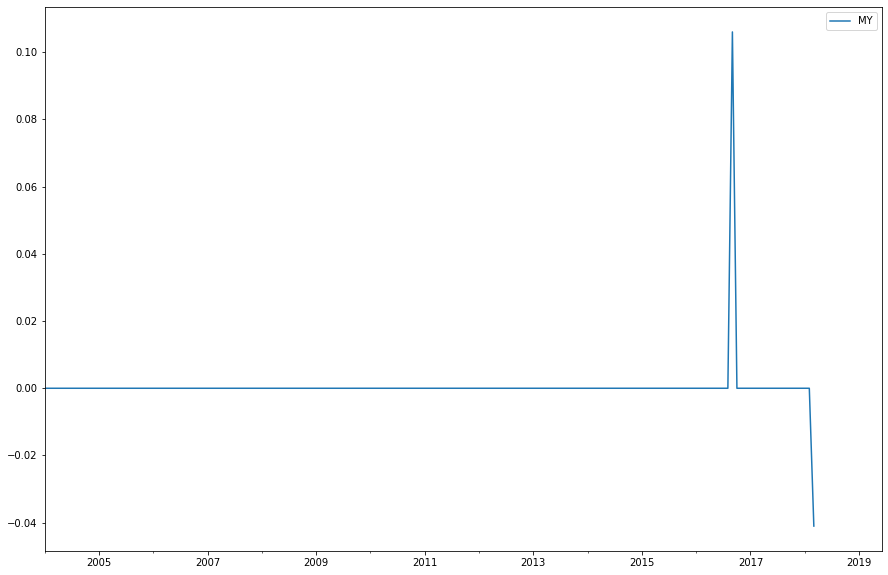

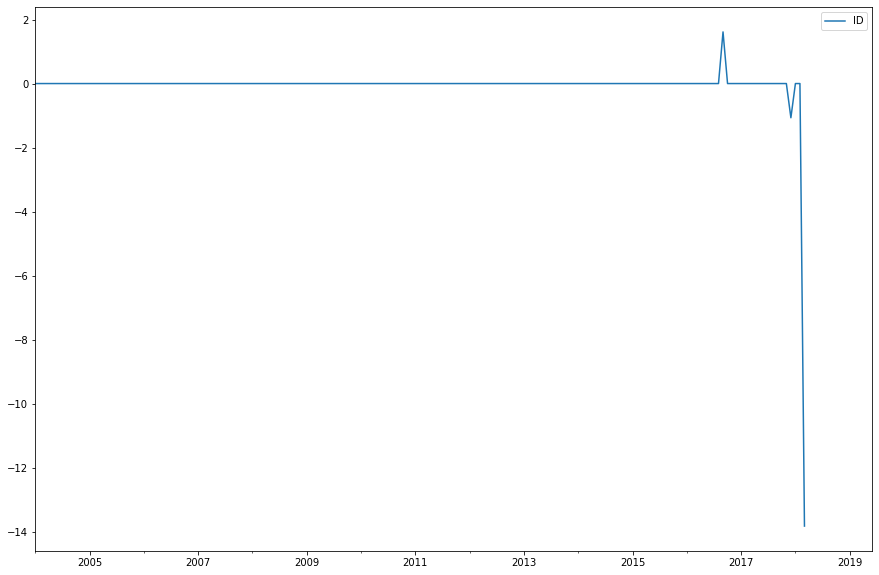

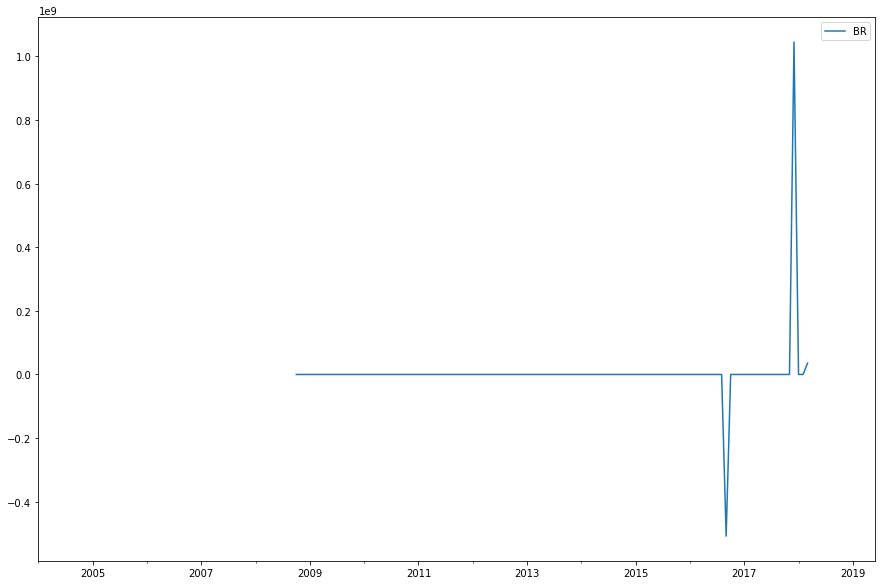

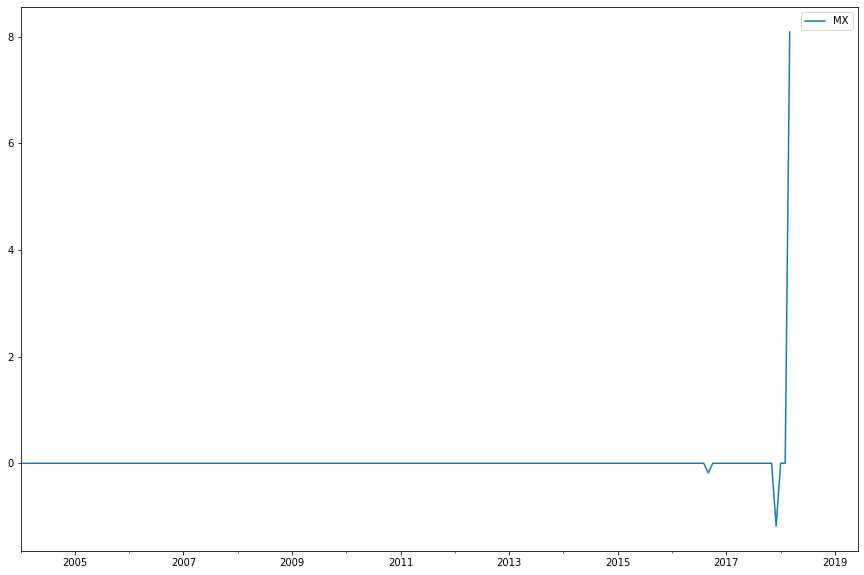

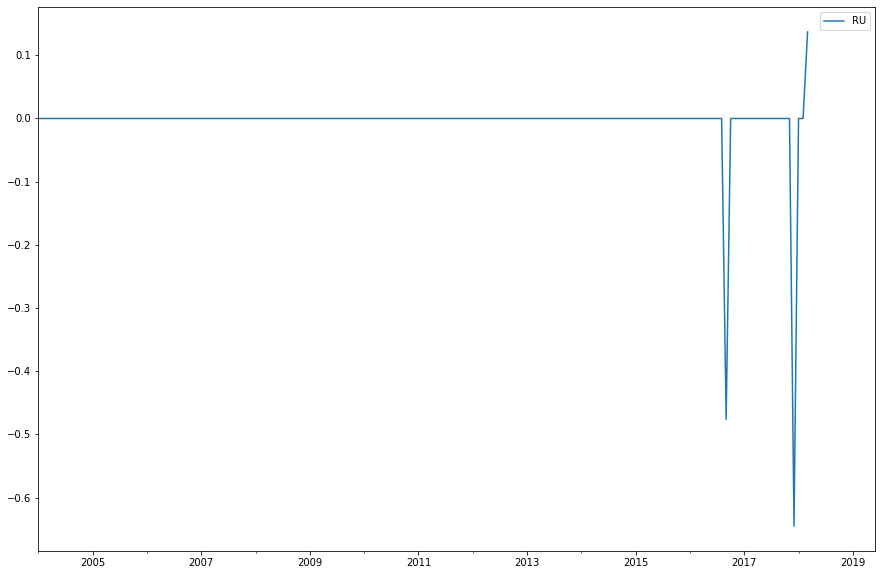

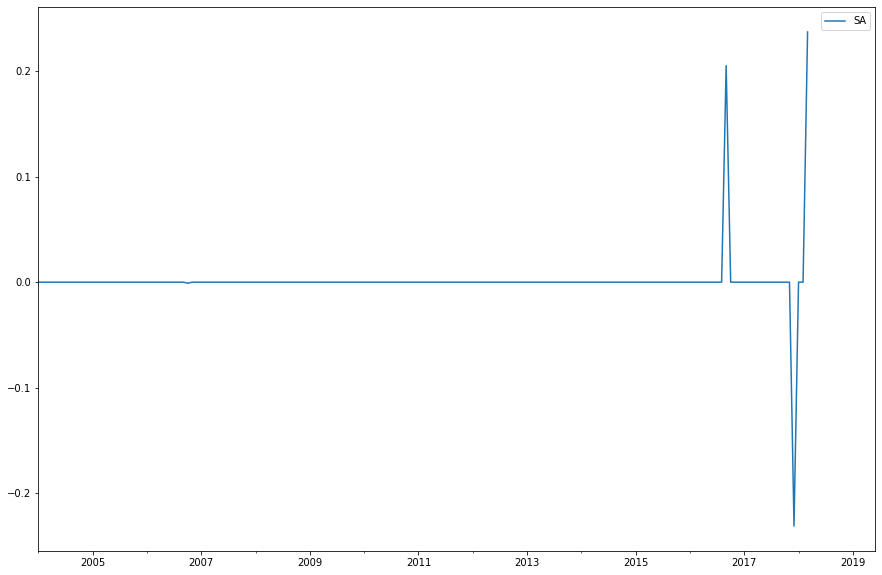

In [16]:
for column in DPS1.columns:
    (DPS1 - emdy.dps1.reindex(emdy.dps1.index))[[column]].loc['2004':].plot(figsize=(15,10))
    plt.legend()
    plt.plot()

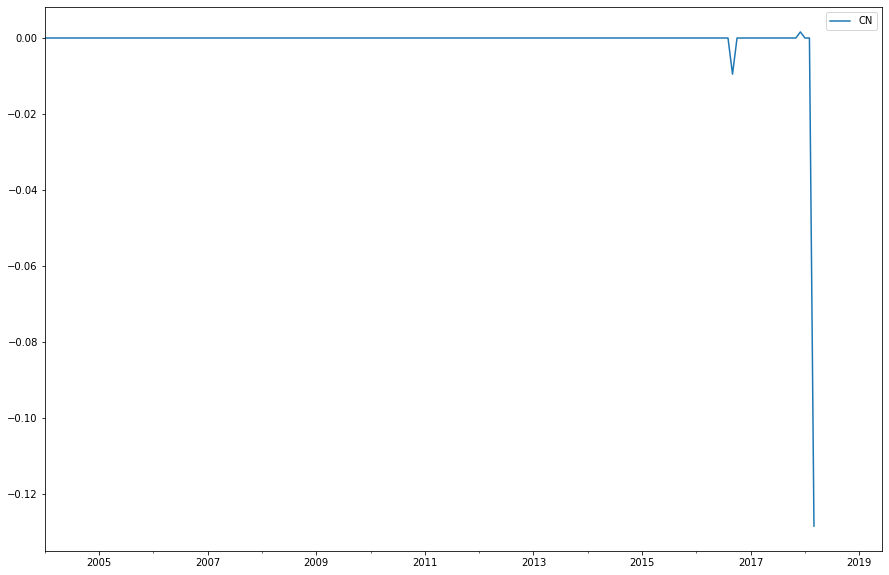

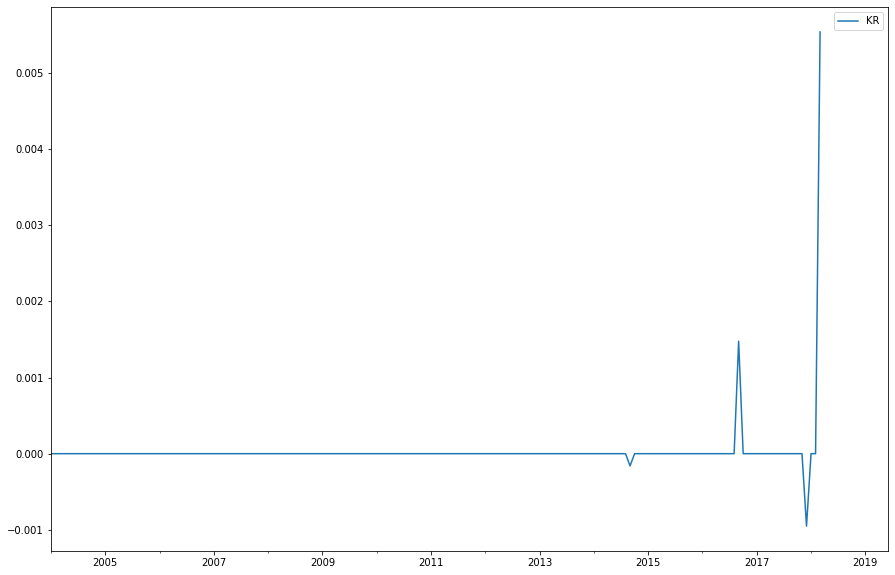

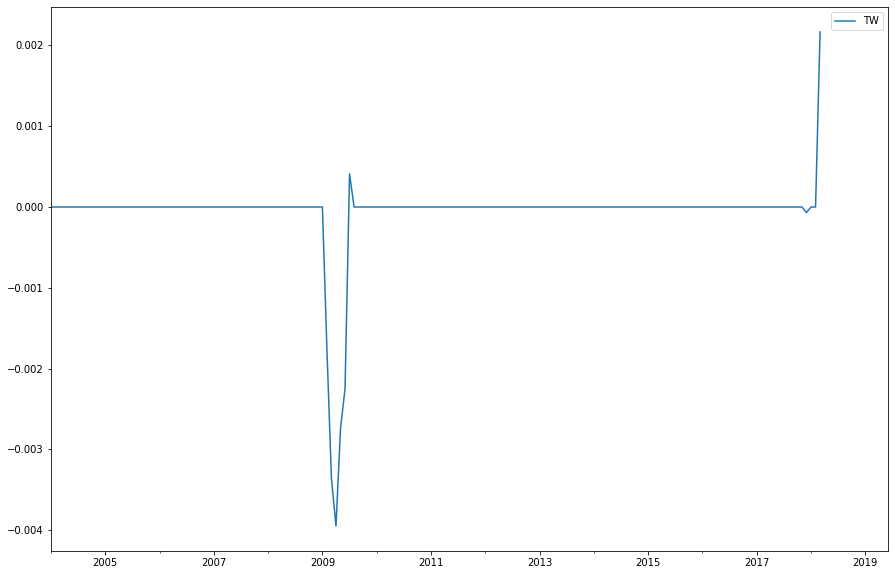

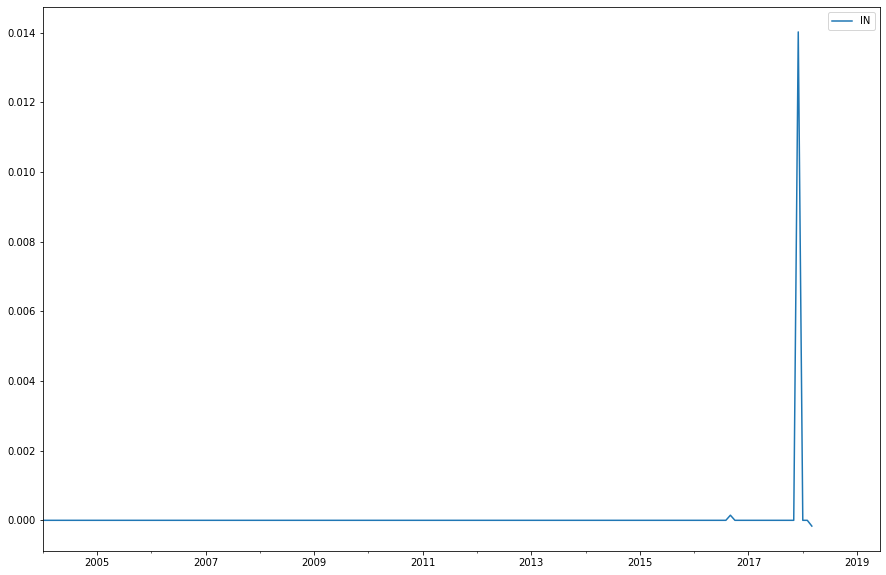

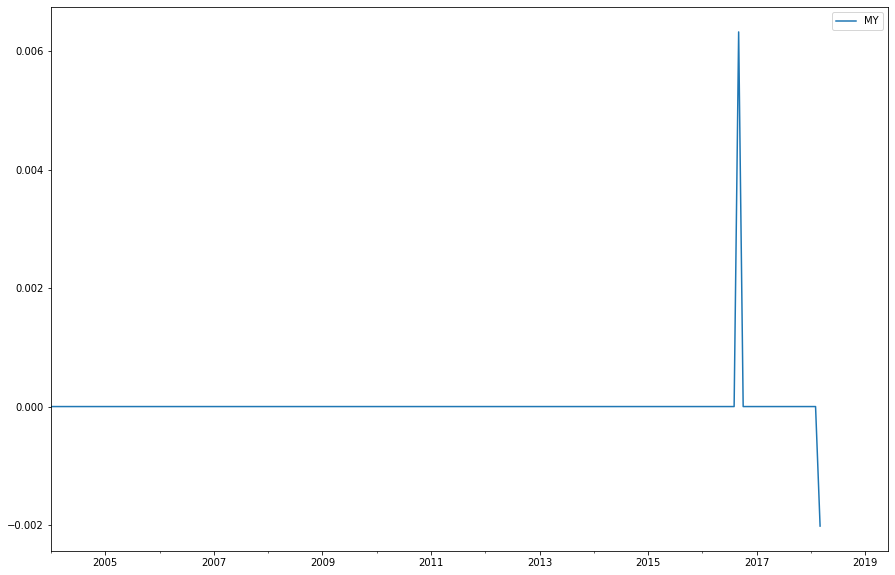

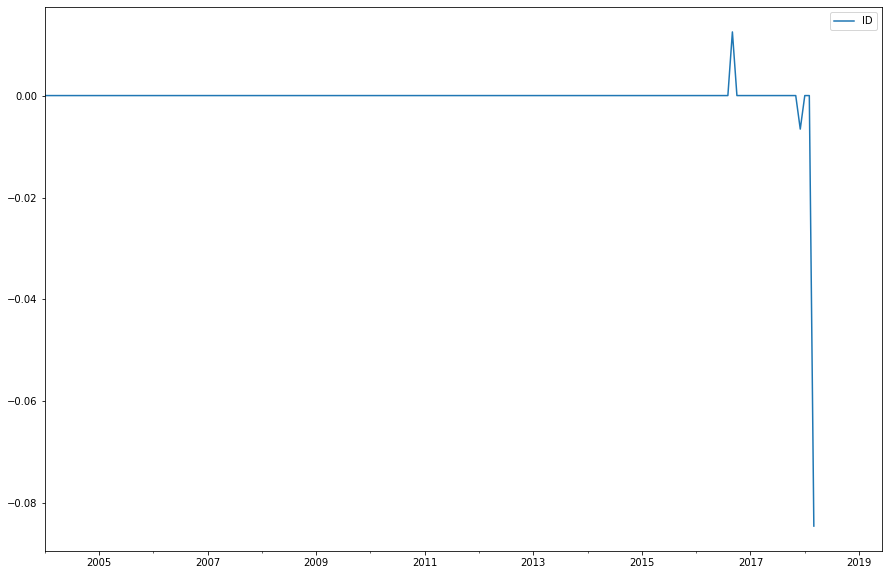

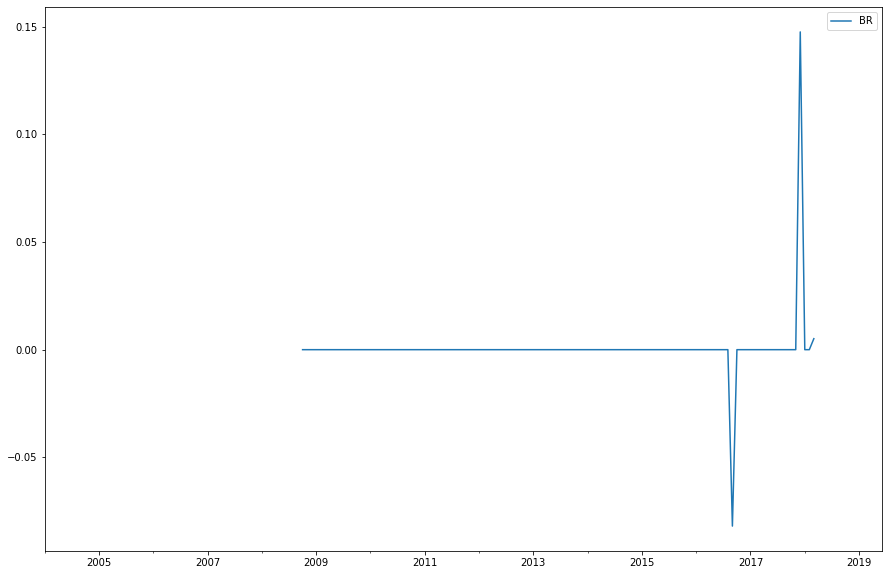

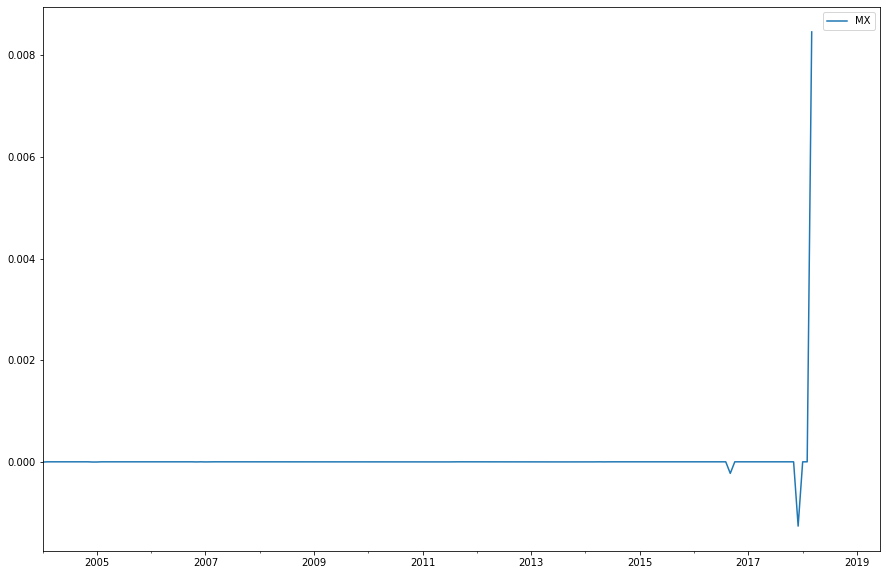

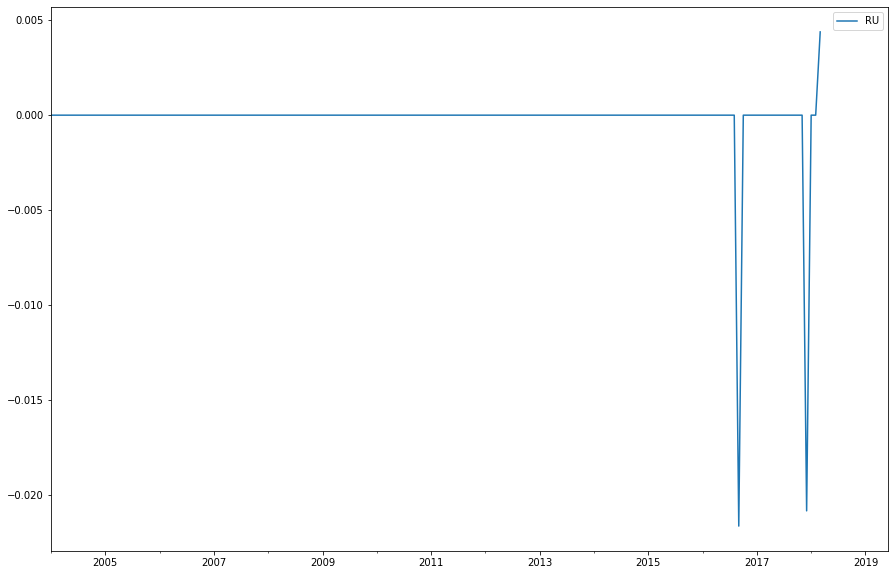

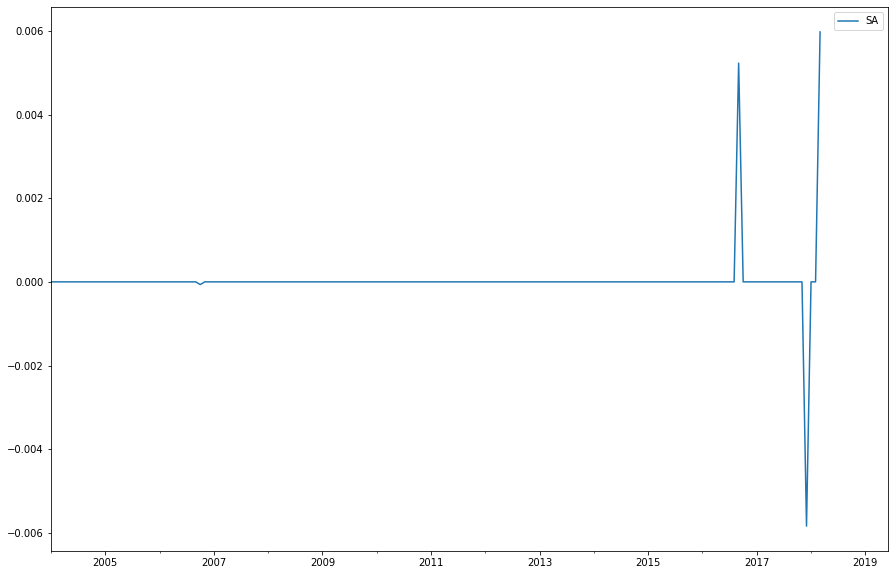

In [17]:
for column in DPS1.columns:
    ((DPS1 - emdy.dps1.reindex(emdy.dps1.index)) / DPS1)[[column]].loc['2004':].plot(figsize=(15,10))
    plt.legend()
    plt.plot()

### yield 차이

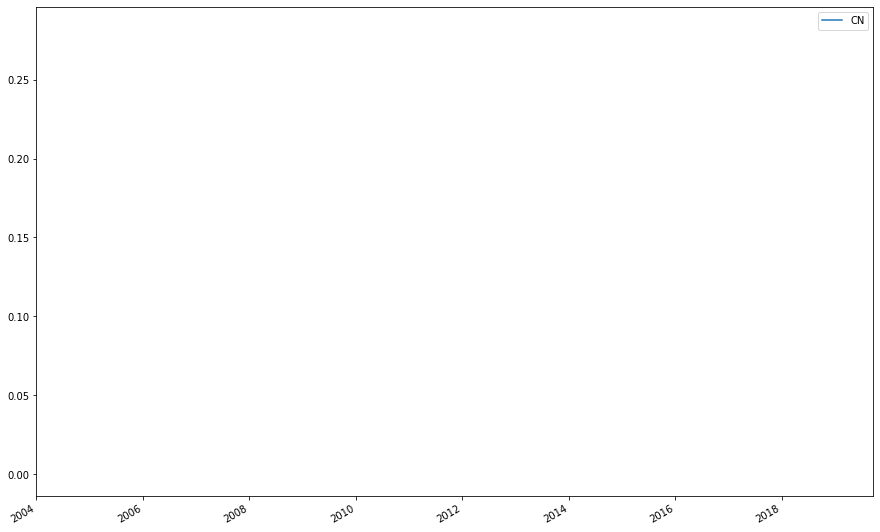

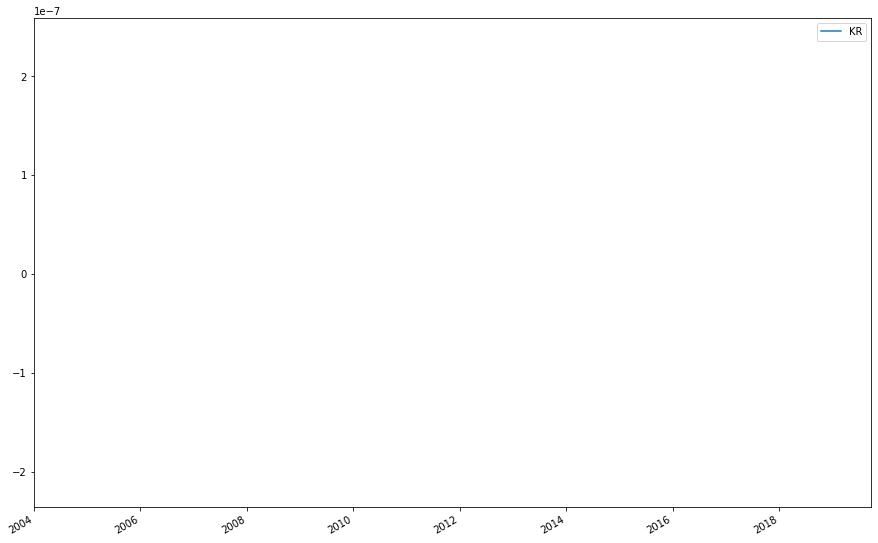

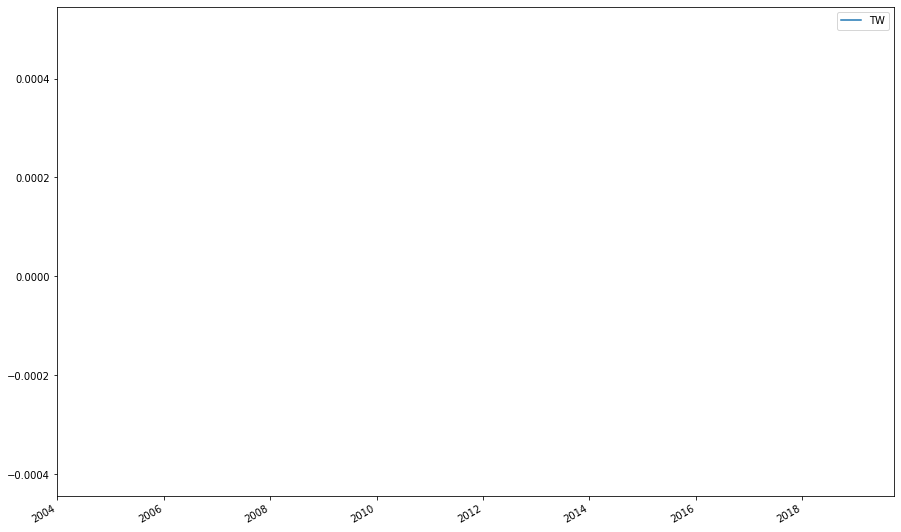

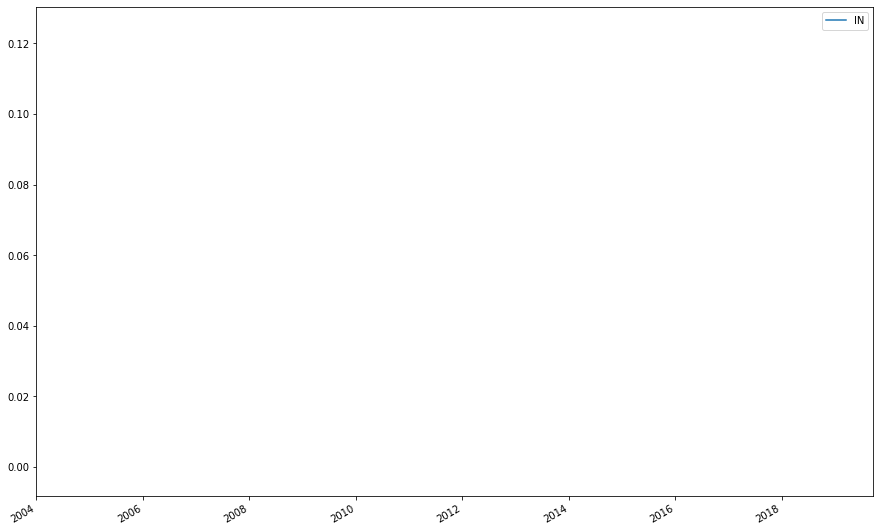

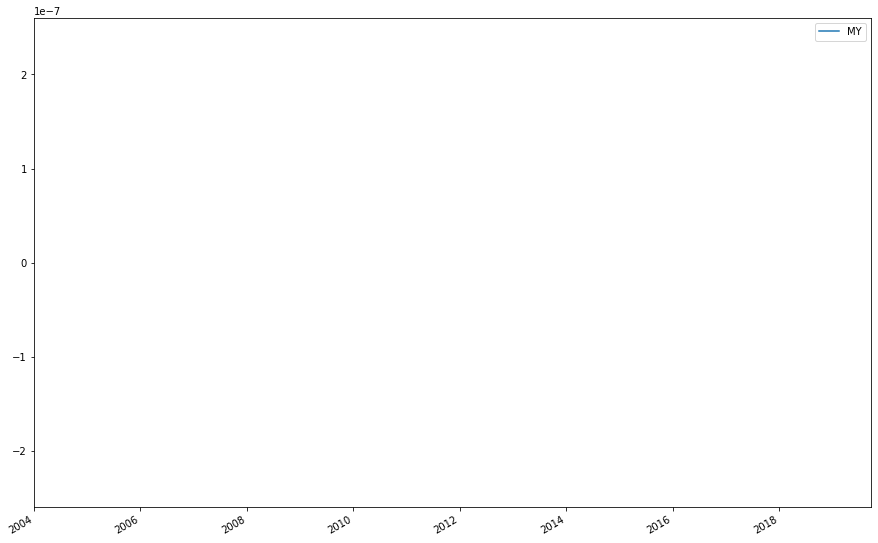

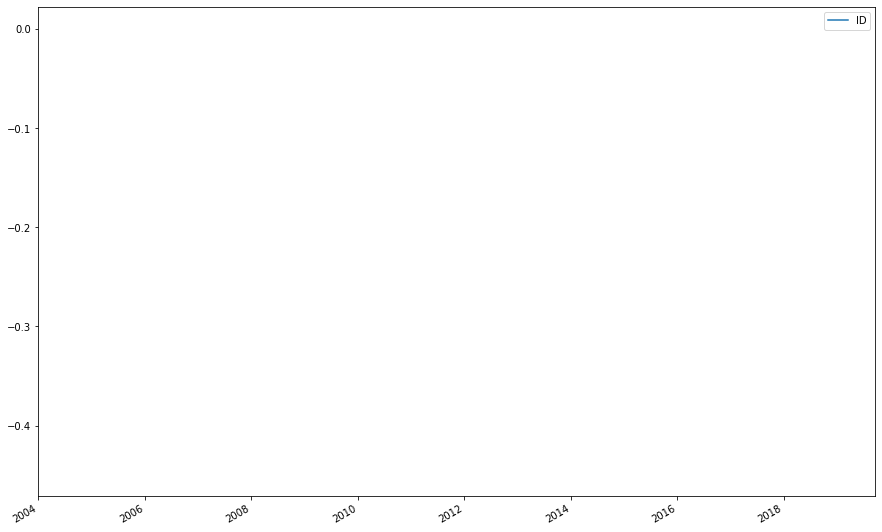

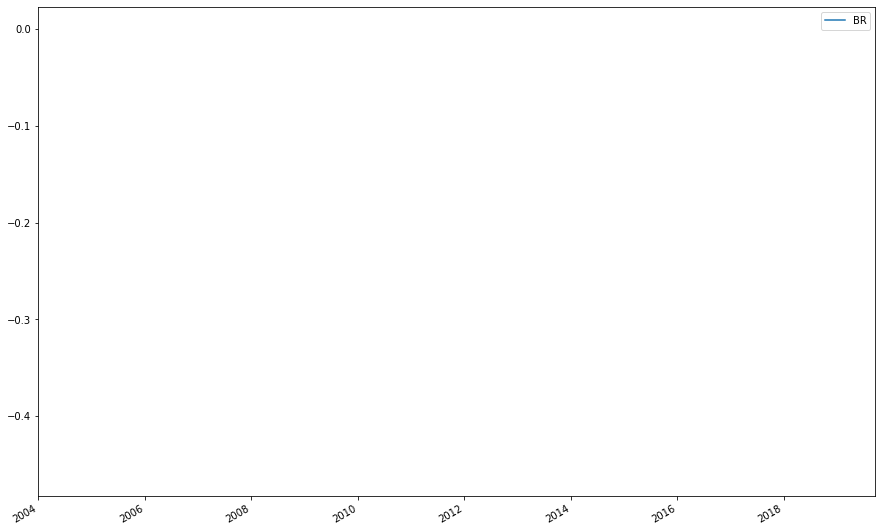

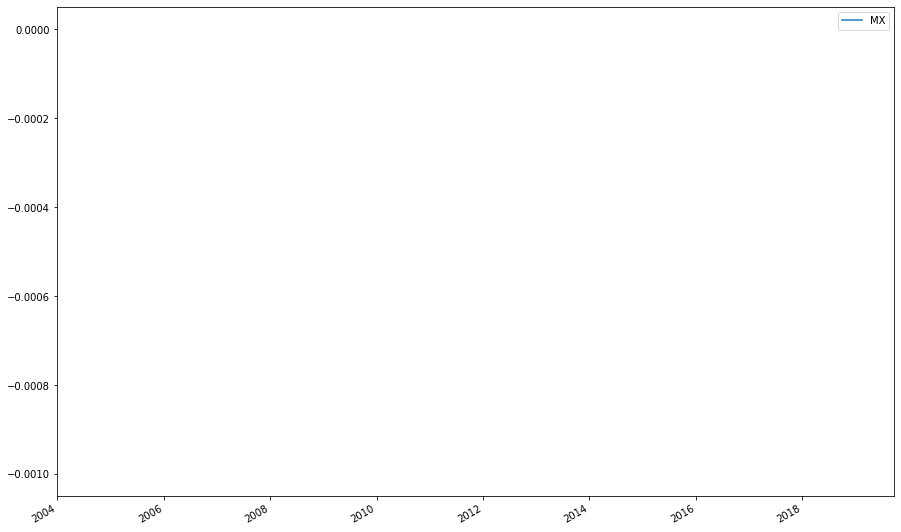

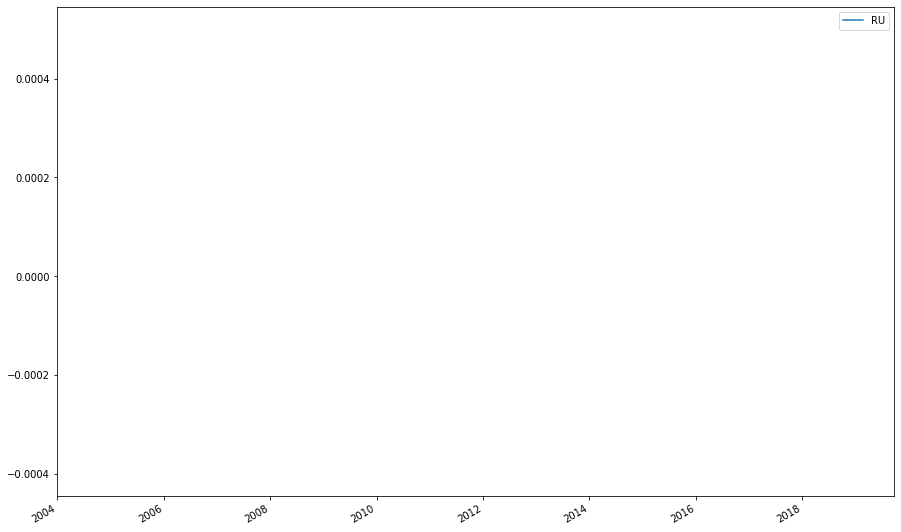

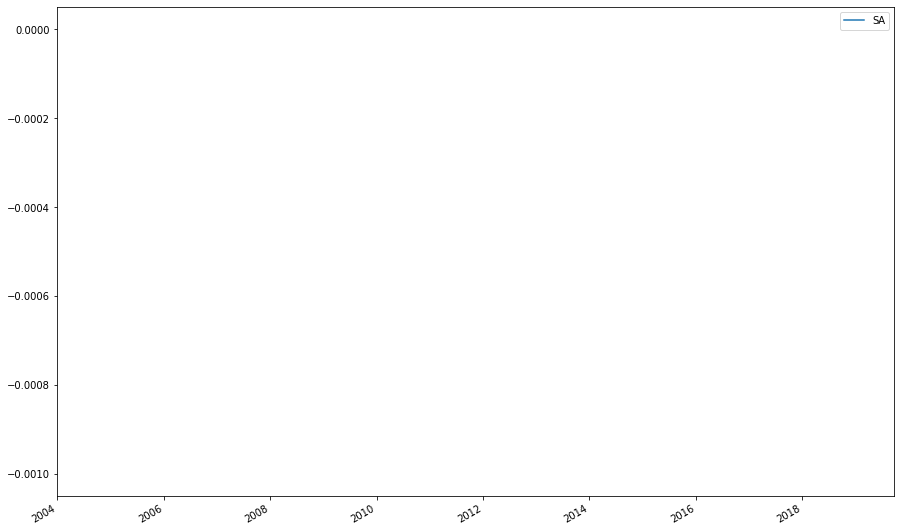

In [18]:
for column in DPS1.columns:
    (yield_ - emdy.yield10.reindex(emdy.yield10.index))[[column]].loc['2004':].plot(figsize=(15,10))
    plt.legend()
    plt.plot()

### PRICE INDEX도 사용하고 DPS, DPS1 차이가 많이 발생한다.

In [19]:
emdy.calculate_signal(CS=0.35, nopos=0.4, minobs1=12, minobs=60, IDN='out')
emdy.set_portfolio_parameter(cs_strategy_type='notional')
emdy.make_portfolio()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\EMDY.py:72: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\EMDY.py:73: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

2020-02-04 08:57:26,952 - EMDY - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 08:57:26,953 - EMDY - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 08:57:26,953 - EMDY - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 08:58:00,305 - EMDY - INFO - [STEP 5 - 2

In [20]:
start_date = '2006-01-01'
end_date = '2018-05-09'

# get r results
emdy_comp_df = pd.read_csv('./past/emdy.csv', header=0, index_col=0, parse_dates=True)
emdy_lag_comp_df = pd.read_csv('./past/emdy_lag.csv', header=0, index_col=0, parse_dates=True)

In [21]:
tester = Tester(emdy)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False, use_bt=False)

2020-02-04 08:58:11,418 - EMDY - INFO - [STEP 6] START BACKTEST
2020-02-04 08:58:11,419 - EMDY - INFO - [STEP 6 - 1] BACKTEST EMDY TIME SERIES
2020-02-04 08:58:12,025 - EMDY - INFO - [STEP 6 - 2] BACKTEST EMDY CROSS SECTIONAL


In [22]:
to_plot = (1.+ emdy_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 2. EMPE

- EMPE와 EMDY 모두 price_index 데이터를 사용하는 데 그게 꽤 차이가 나는 것 같다.

In [23]:
empe = EMPE(strategy_name="EMPE", asset_type="EMERGING")
empe.load_index_and_return(from_db=True, save_file=True)

2020-02-04 08:58:13,941 - EMPE - INFO - [STEP 0] START LOGGING EMPE
2020-02-04 08:58:13,942 - EMPE - INFO - [STEP 1] LOAD DATA
2020-02-04 08:58:13,943 - EMPE - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 08:58:13,943 - EMPE - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 08:58:16,915 - EMPE - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 08:58:19,451 - EMPE - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 08:58:38,349 - EMPE - INFO - [STEP 1 - 4] MERGE BLOOM AND PAST DATA
2020-02-04 08:58:38,356 - EMPE - INFO - [STEP 1 - 5] SAVE RETURN DATA INTO CSV FORMAT


In [24]:
empe.raw_index = empe.index * emindex1.reindex(empe.raw_index.index).iloc[0]

In [25]:
empe.load_strategy_data1(table='DS', origin1='EPS-em', origin2='EPS1-em')
empe.load_strategy_data2(table='bloom', origin='10Yield-em')
empe.set_rebalance_period(cs_freq='month', ts_freq='month')

2020-02-04 08:58:43,702 - EMPE - INFO - [STEP 2] SET REBALANCE PERIOD


In [26]:
eps = pd.read_csv(os.path.join(data_path, "EPS-em.csv"), index_col=0, parse_dates=True)
eps.index.name = 'tdate'
eps.columns.name = 'ticker'

eps1 = pd.read_csv(os.path.join(data_path, "EPS1-em.csv"), index_col=0, parse_dates=True)
eps1.index.name = 'tdate'
eps1.columns.name = 'ticker'

yield10 = pd.read_csv(os.path.join(data_path, '10Yield-em.csv'), index_col=0, parse_dates=True)
yield10.index.name = 'tdate'
yield10.columns.name = 'ticker'

### EPS

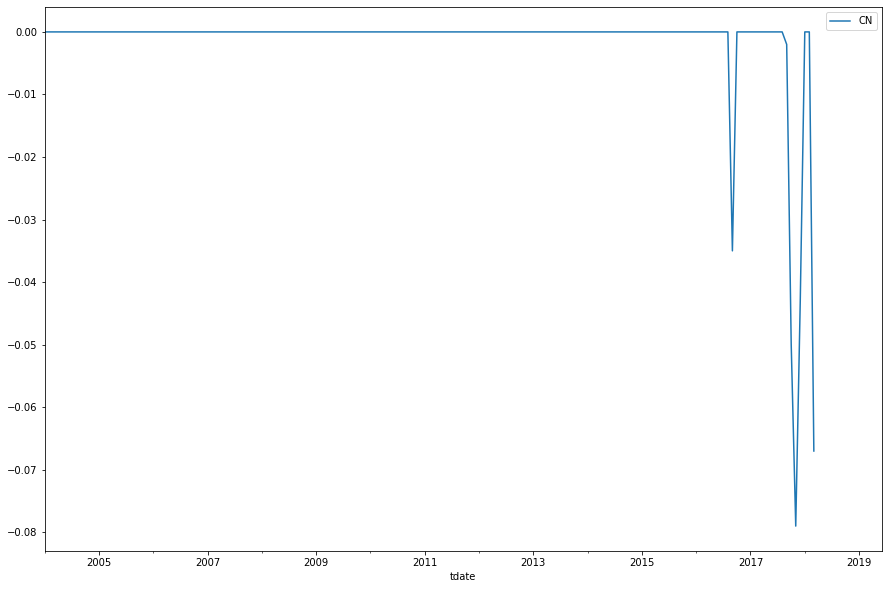

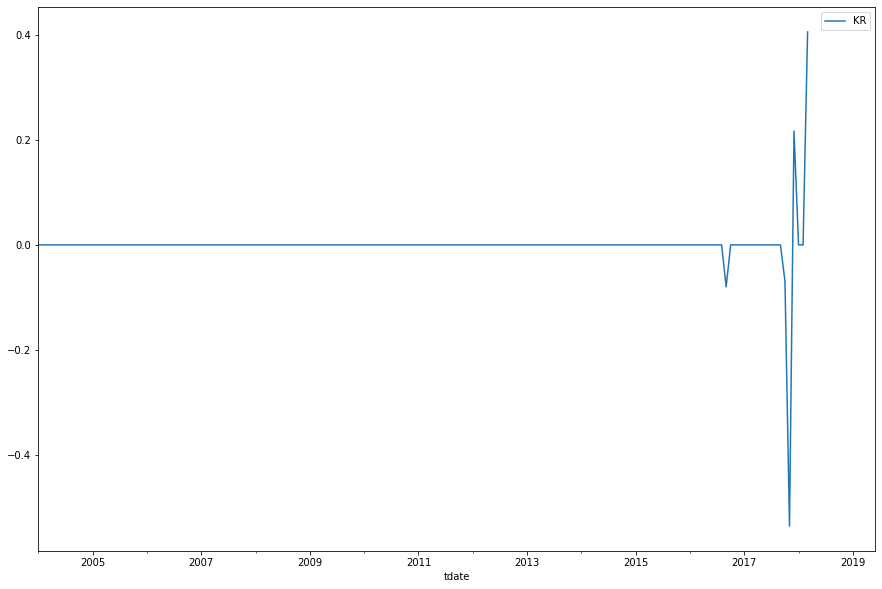

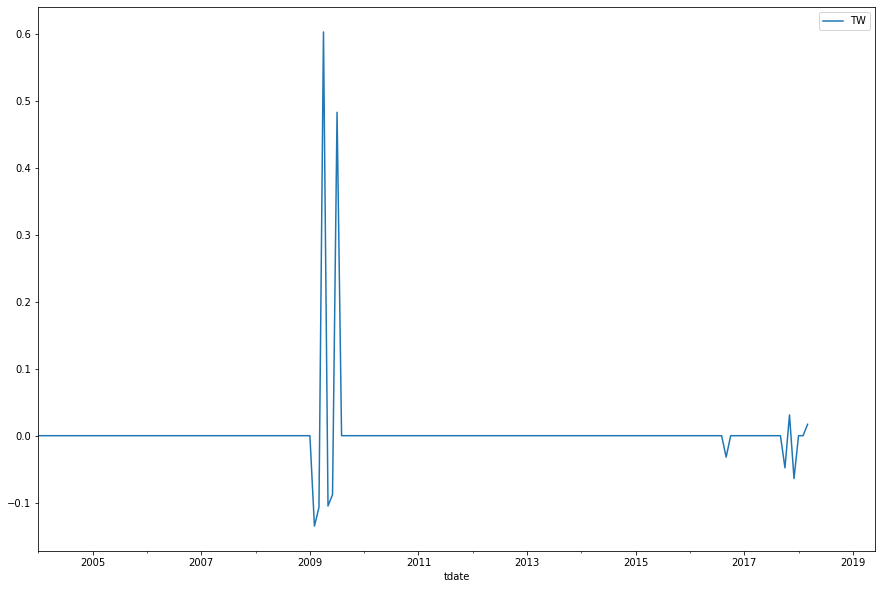

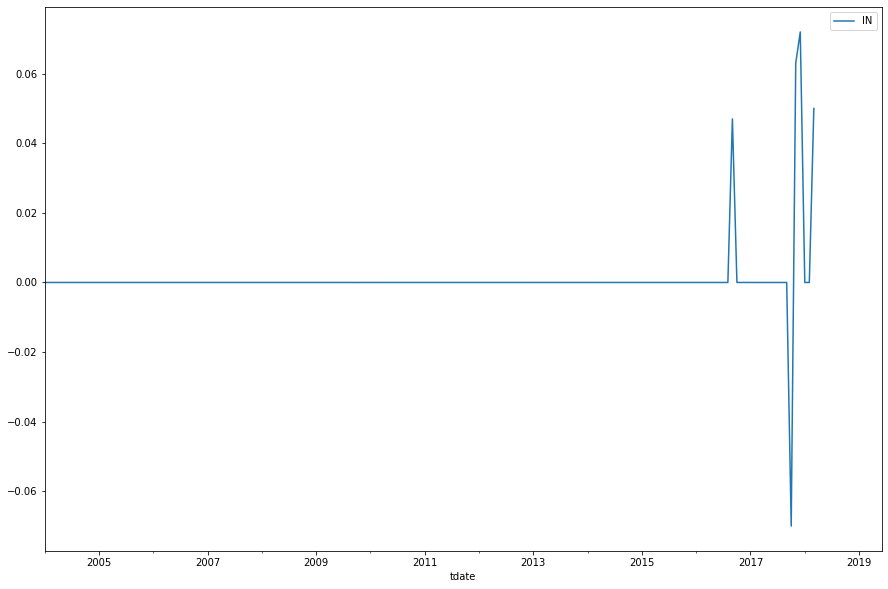

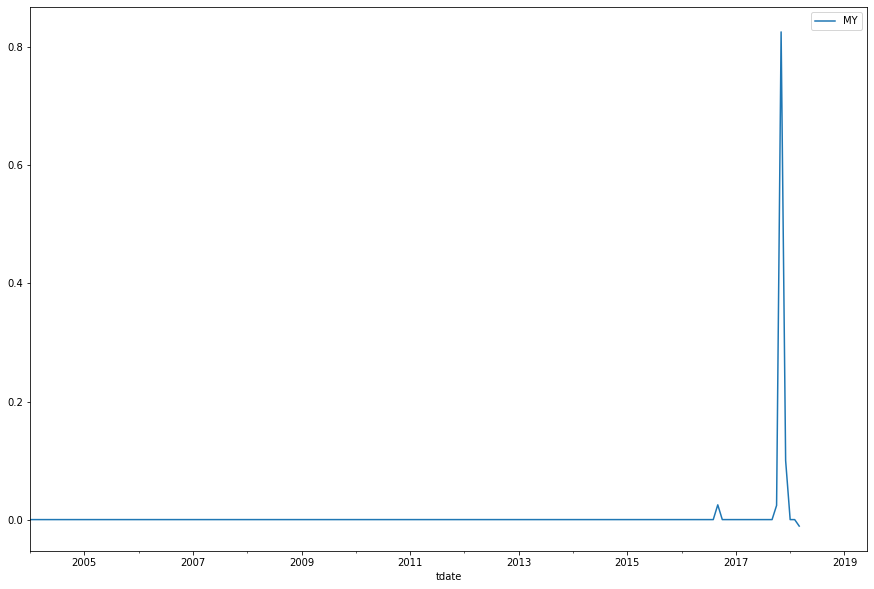

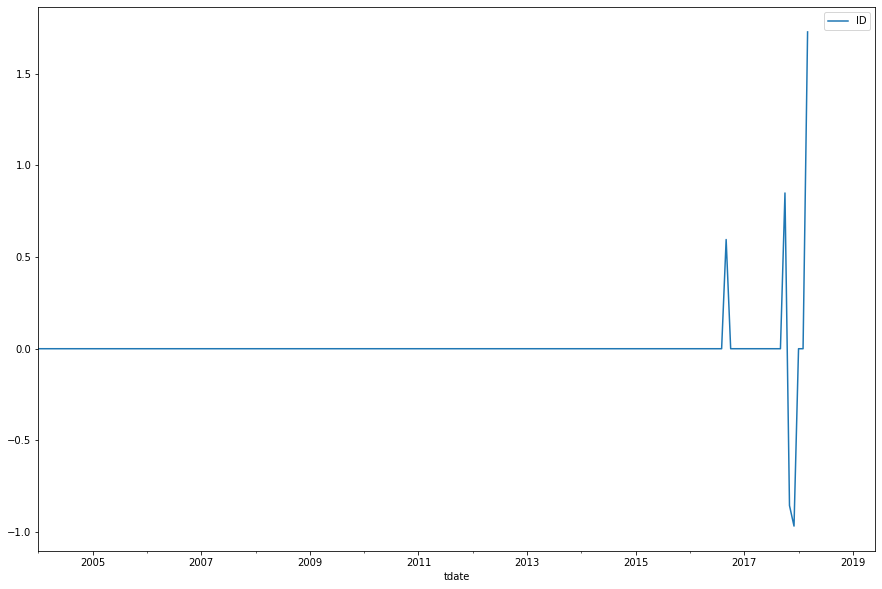

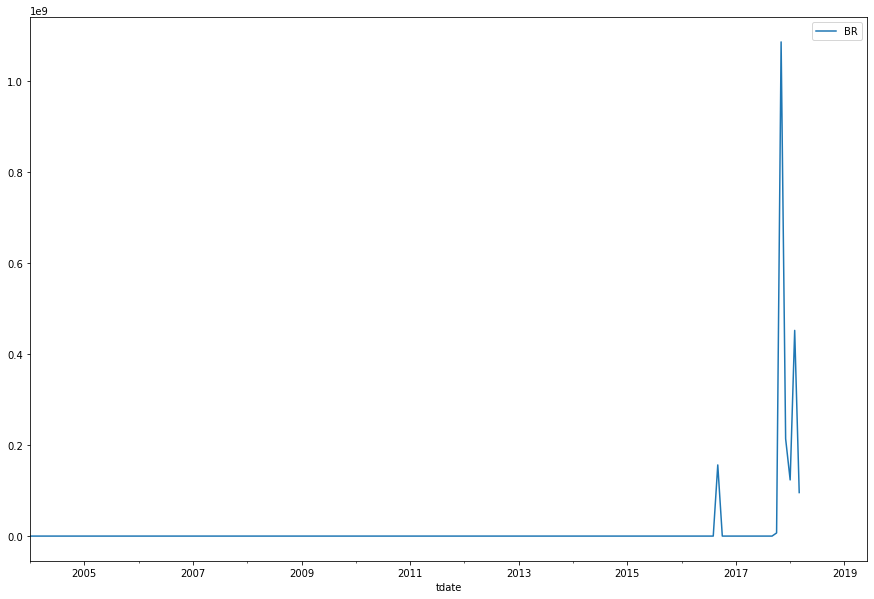

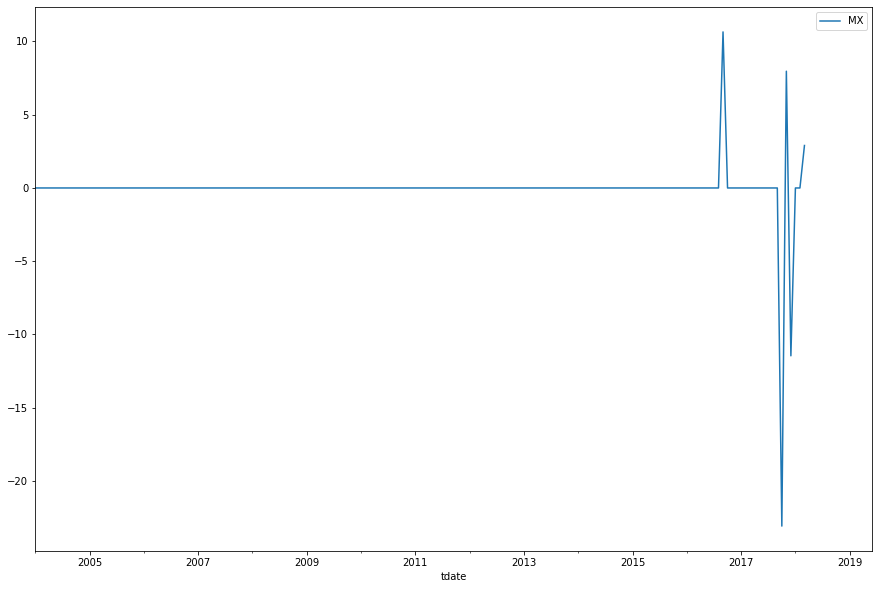

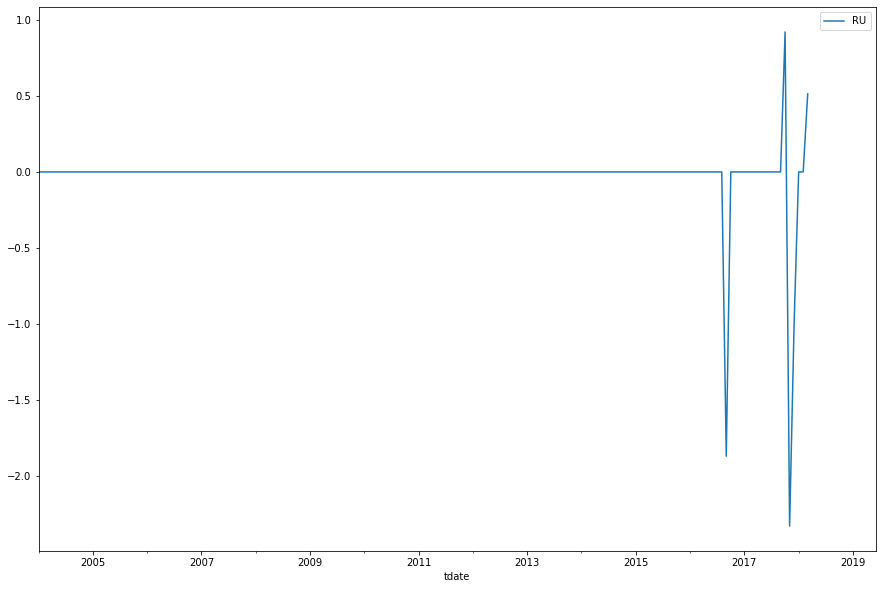

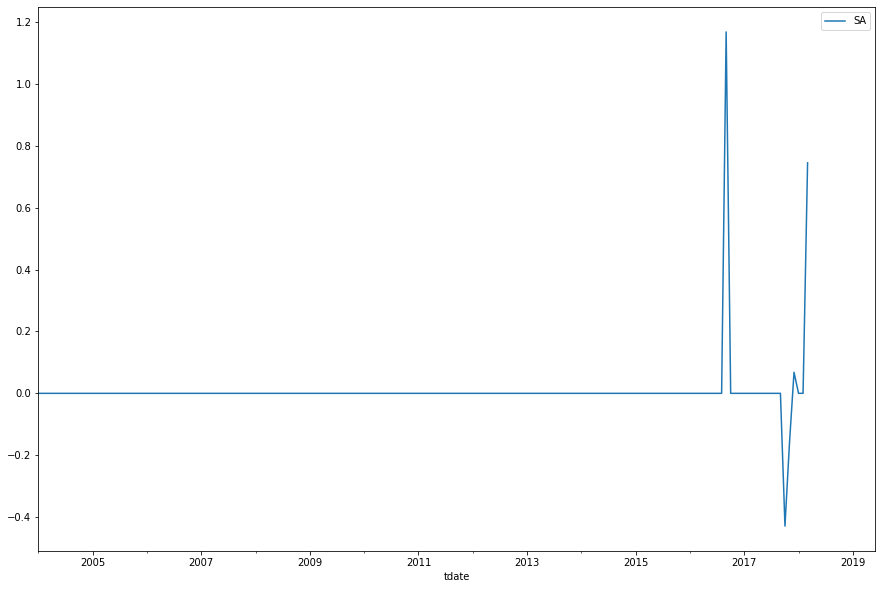

In [27]:
for column in eps.columns:
    (eps - empe.eps.reindex(empe.eps.index))[[column]].loc['2004':].plot(figsize=(15,10))
    plt.legend()
    plt.plot()

### EPS1

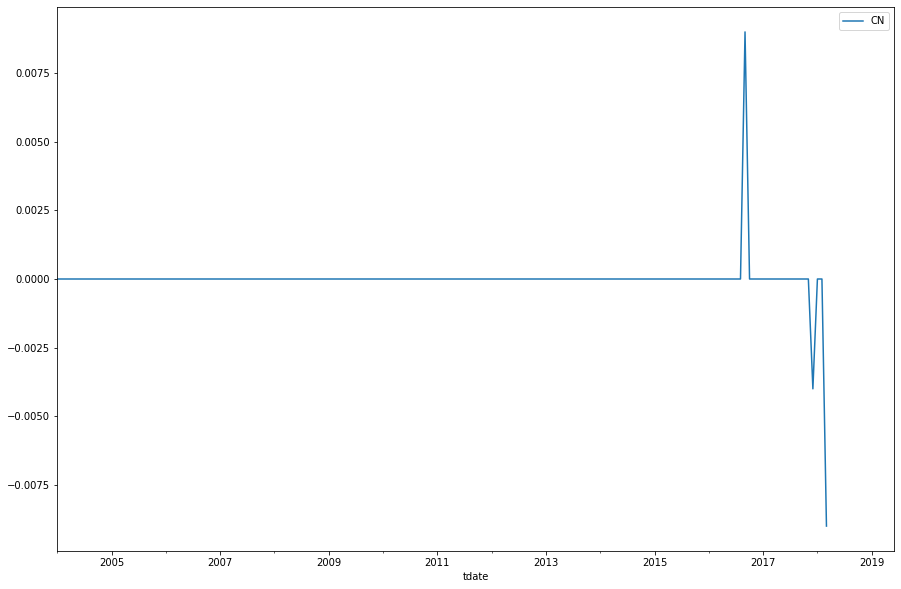

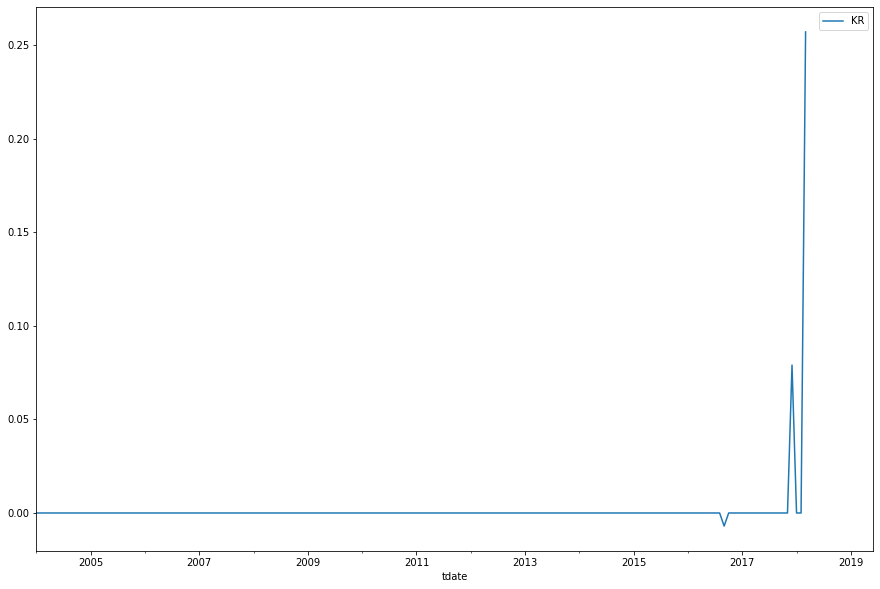

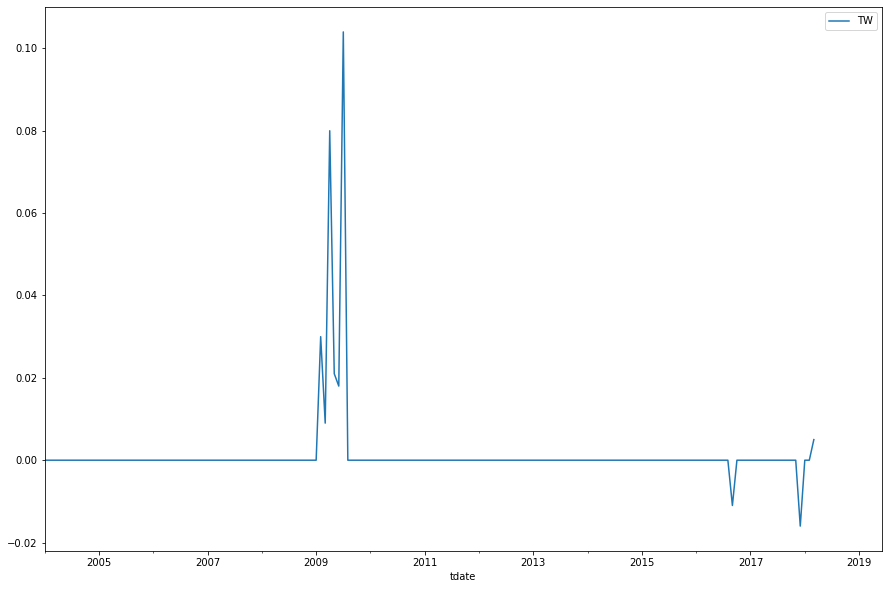

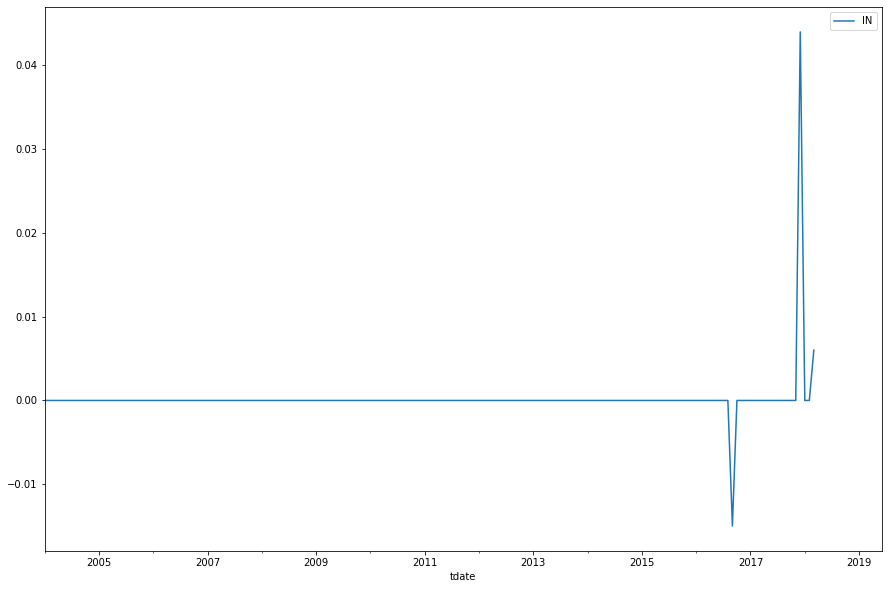

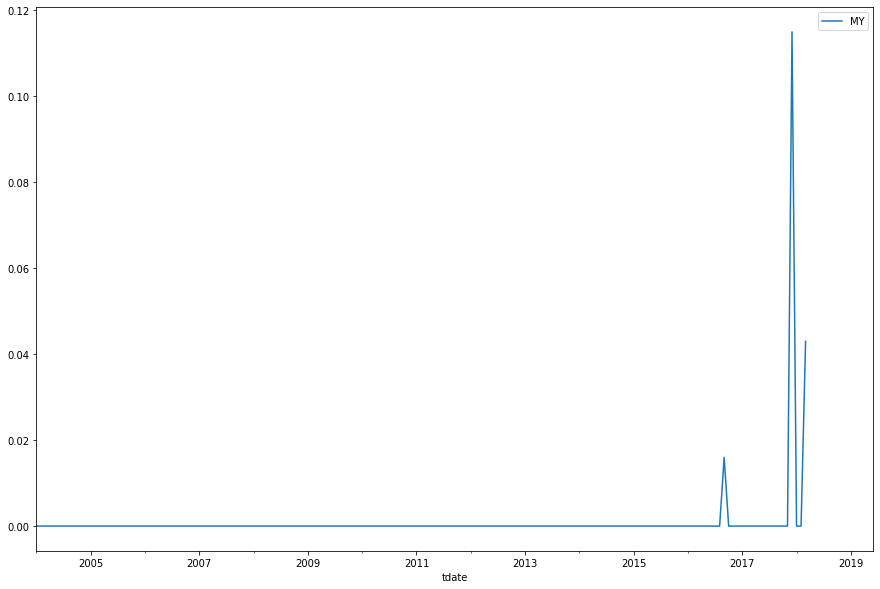

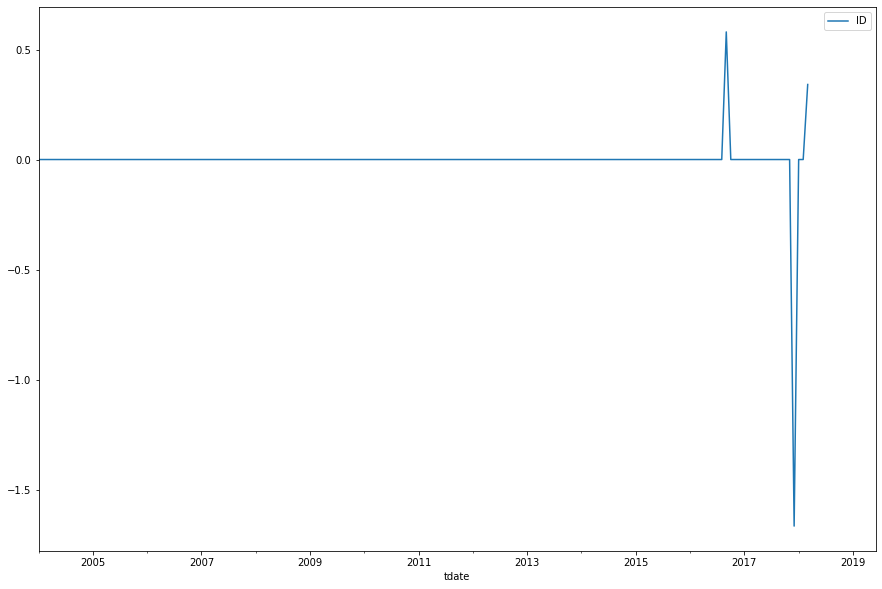

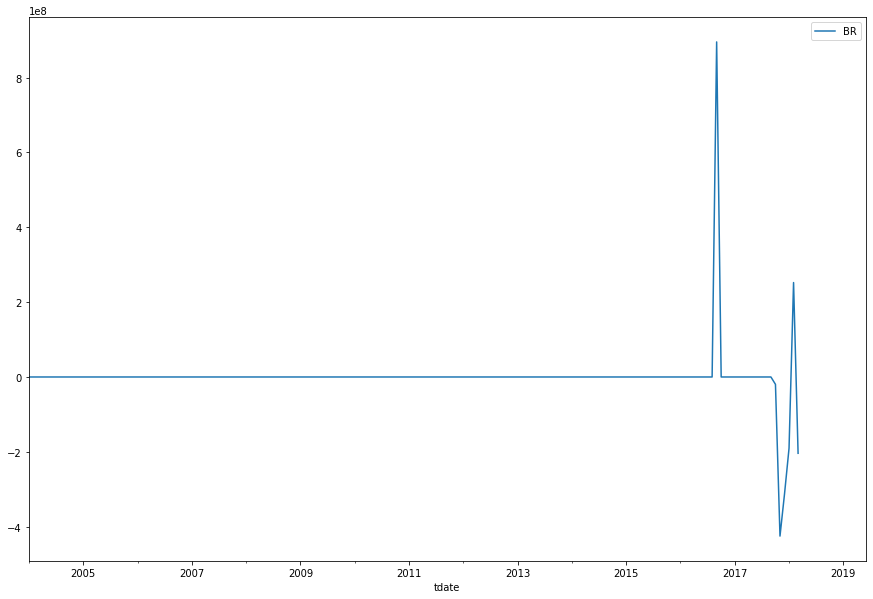

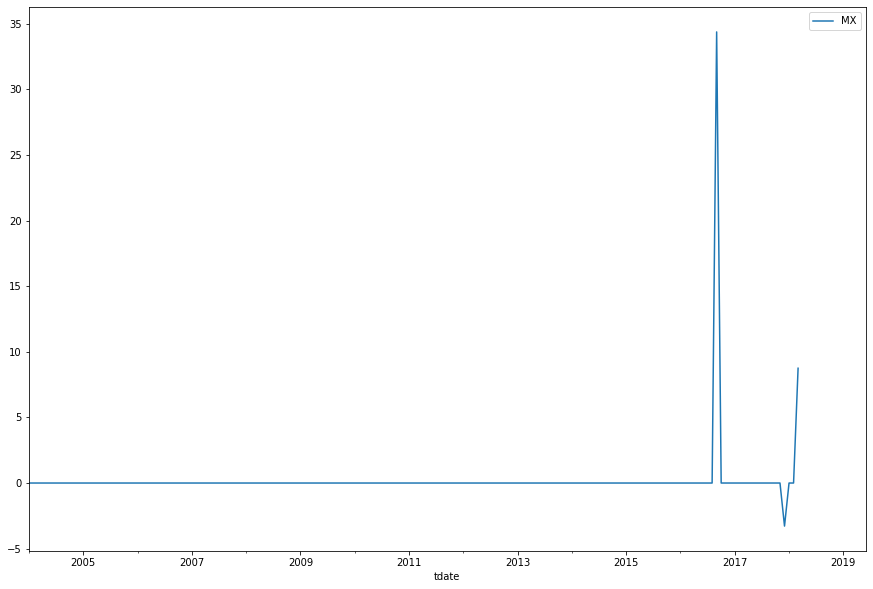

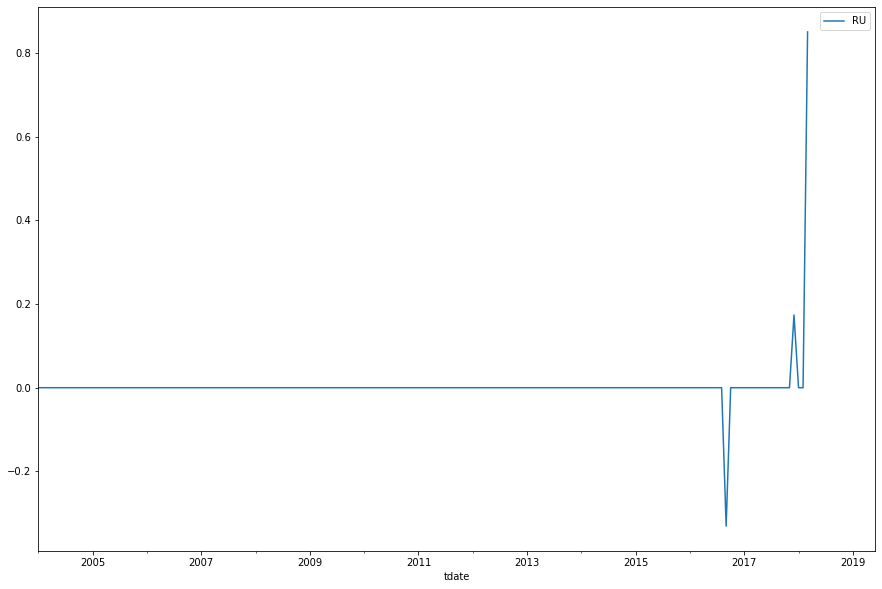

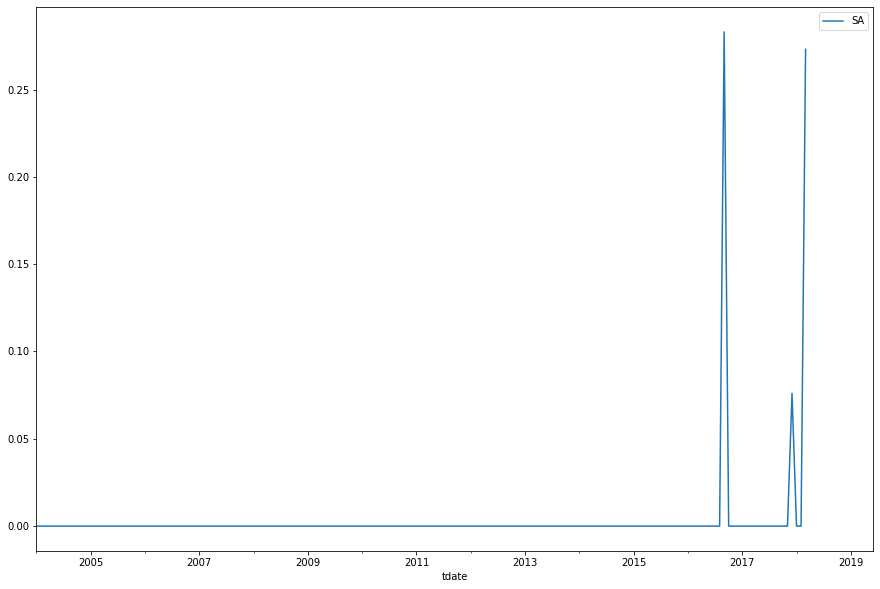

In [28]:
for column in eps.columns:
    (eps1 - empe.eps1.reindex(empe.eps1.index))[[column]].loc['2004':].plot(figsize=(15,10))
    plt.legend()
    plt.plot()

In [29]:
empe.calculate_signal(CS=0.35, nopos=0.4, minobs1=12, minobs=60, IDN='out')
empe.set_portfolio_parameter(cs_strategy_type='notional')
empe.make_portfolio()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\EMPE.py:63: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\EMPE.py:64: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

2020-02-04 08:58:48,799 - EMPE - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 08:58:48,799 - EMPE - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 08:58:48,799 - EMPE - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 08:59:20,362 - EMPE - INFO - [STEP 5 - 2

### RAW_INDEX

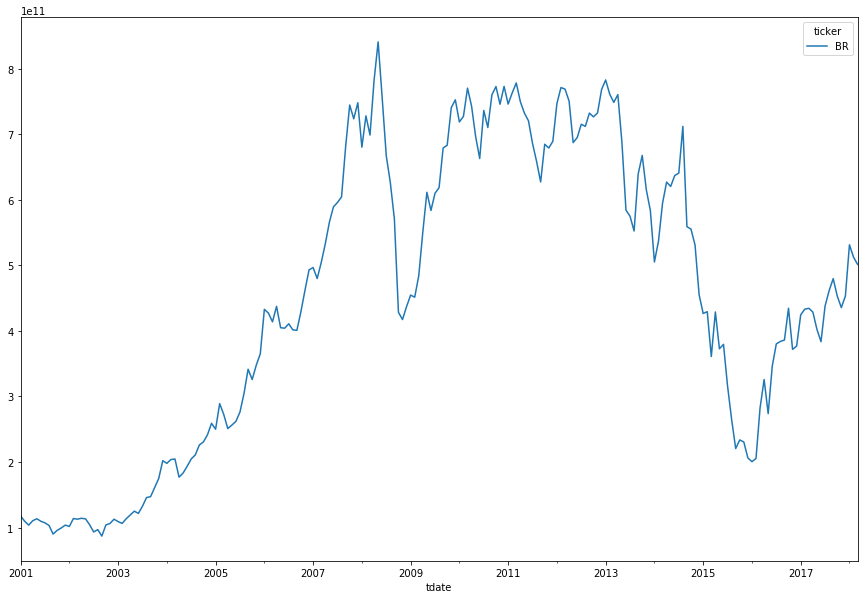

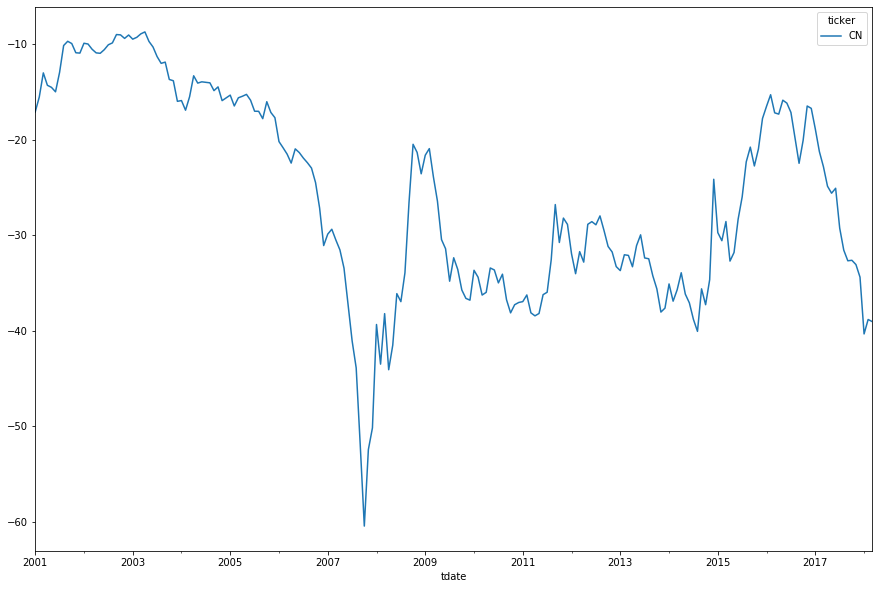

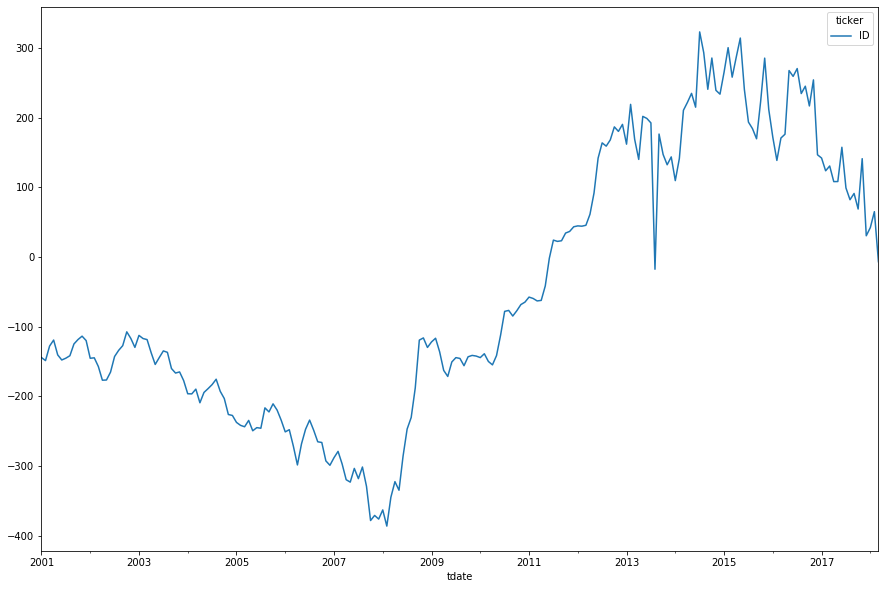

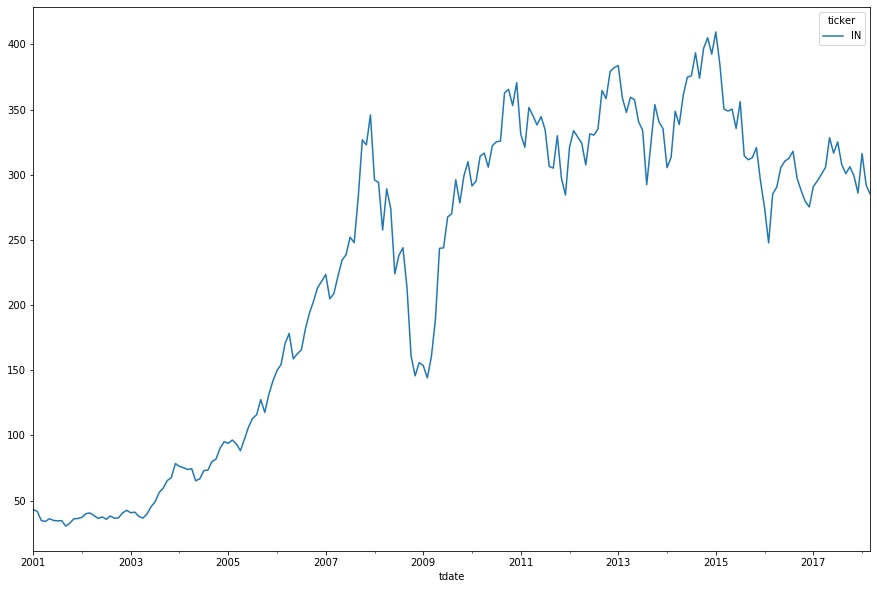

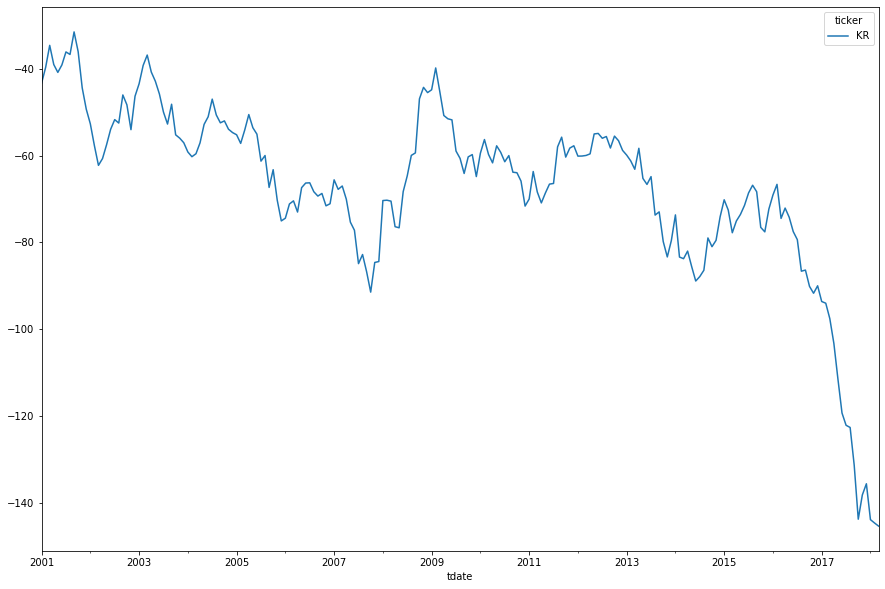

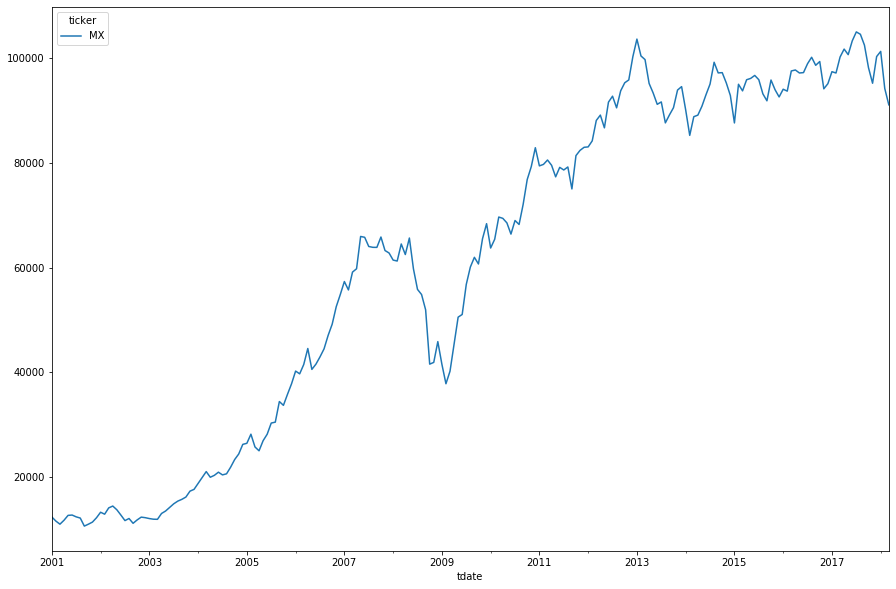

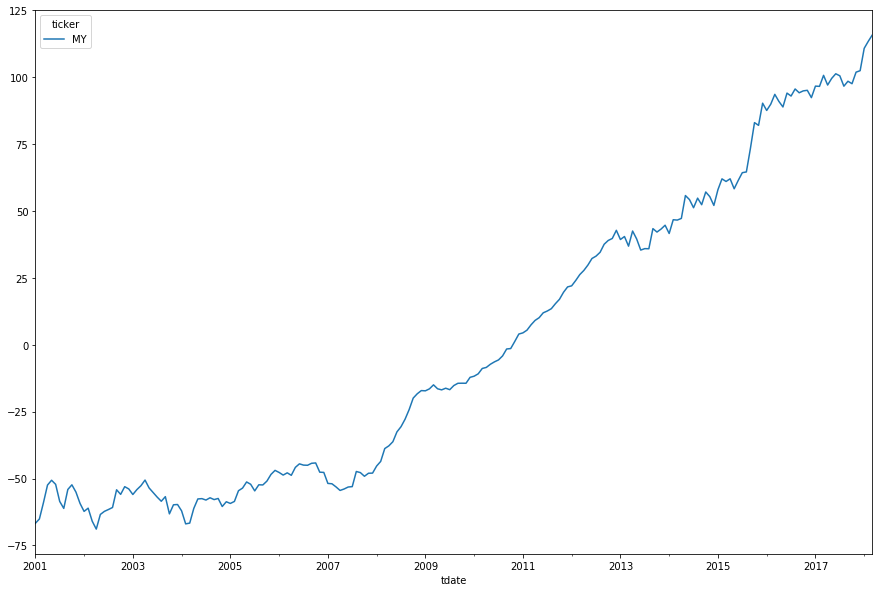

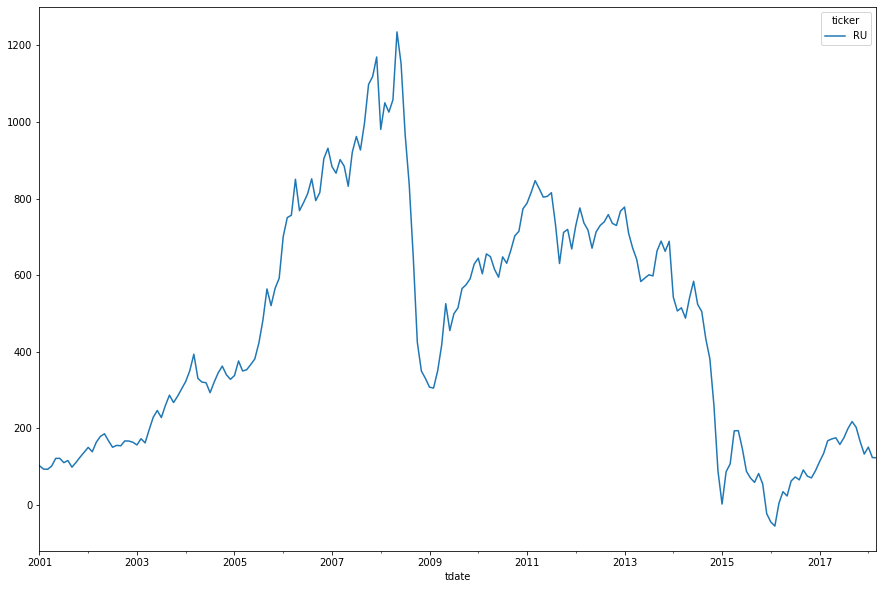

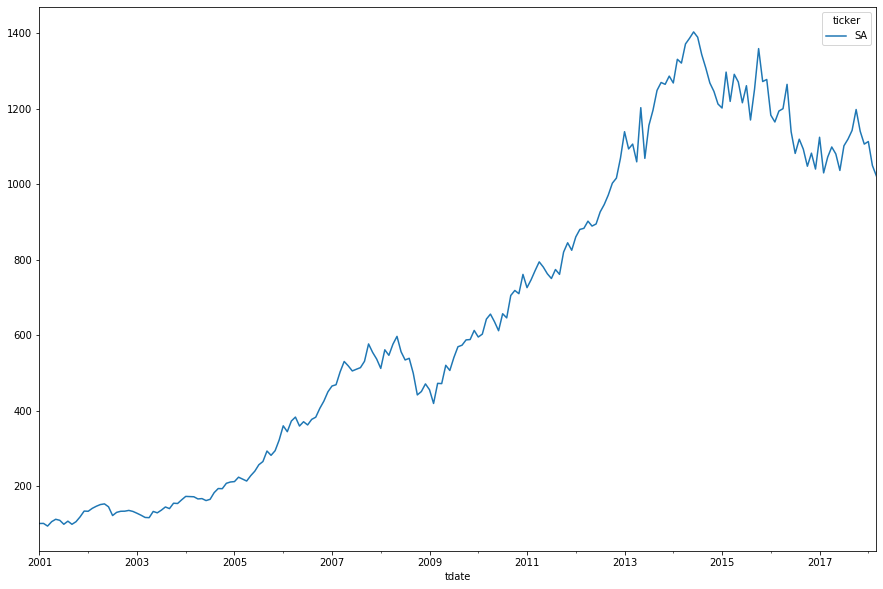

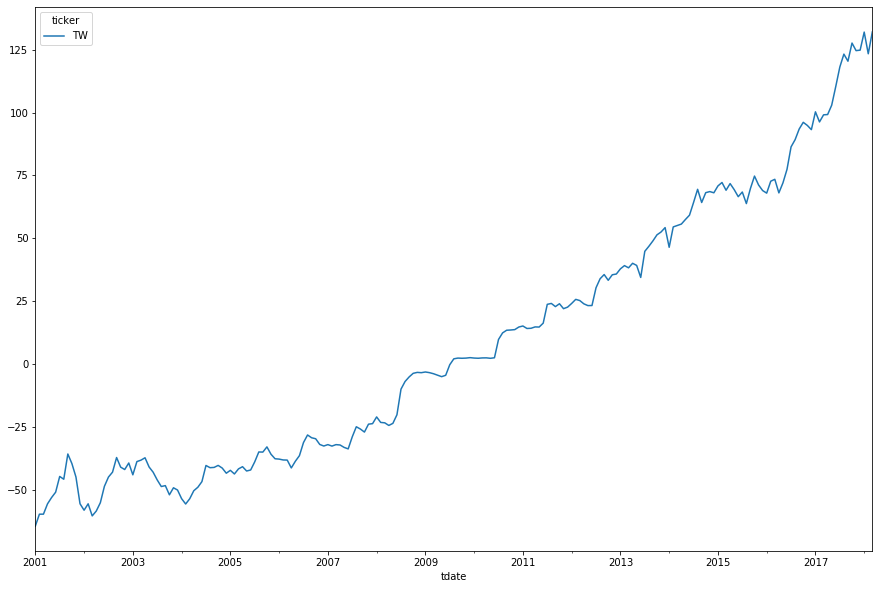

In [30]:
for column in empe.raw_index.columns:
    (empe.raw_index.reindex(raw_index.index) - raw_index).loc['2001':][[column]].plot(figsize=(15,10))
    plt.show()

In [31]:
start_date = '2006-01-01'
end_date = '2018-05-09'

# get r results
empe_comp_df = pd.read_csv('./past/empe.csv', header=0, index_col=0, parse_dates=True)
empe_lag_comp_df = pd.read_csv('./past/empe_lag.csv', header=0, index_col=0, parse_dates=True)

In [32]:
tester = Tester(empe)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False, use_bt=False)

2020-02-04 08:59:41,343 - EMPE - INFO - [STEP 6] START BACKTEST
2020-02-04 08:59:41,343 - EMPE - INFO - [STEP 6 - 1] BACKTEST EMPE TIME SERIES
2020-02-04 08:59:41,989 - EMPE - INFO - [STEP 6 - 2] BACKTEST EMPE CROSS SECTIONAL


In [33]:
to_plot = (1.+ empe_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 3. EMPM

In [46]:
empm = EMPM(strategy_name="EMPM", asset_type="EMERGING")
empm.load_index_and_return(from_db=True, save_file=True)
empm.set_rebalance_period(ts_freq='month', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
empm.calculate_signal(CS=0.35, minobs=260, minobs1=52, longlen1=52, longlen2=13, shortlen=2)
empm.set_portfolio_parameter(cs_strategy_type='notional')
empm.make_portfolio()

2020-02-04 14:30:59,655 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 14:30:59,655 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 14:30:59,674 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 14:30:59,674 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 14:30:59,675 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 14:30:59,675 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 14:30:59,683 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 14:30:59,683 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 14:31:02,956 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 14:31:02,956 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 14:31:06,123 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 14:31:06,123 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 14:31:2

In [47]:
start_date = '2006-01-01'
end_date = '2018-05-09'

# get r results
empm_comp_df = pd.read_csv('./past/empm.csv', header=0, index_col=0, parse_dates=True)
empm_lag_comp_df = pd.read_csv('./past/empm_lag.csv', header=0, index_col=0, parse_dates=True)

In [50]:
tester = Tester(empm)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False, use_bt=True)

2020-02-04 14:35:27,901 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 14:35:27,901 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 14:35:27,903 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 14:35:27,903 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES


EMPM
0% [############################# ] 100% | ETA: 00:00:00

2020-02-04 14:35:31,951 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2020-02-04 14:35:31,951 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL


EMPM
0% [############################# ] 100% | ETA: 00:00:00

In [51]:
to_plot = (1.+ empm_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 4. EMSS

In [38]:
emss = EMSS(strategy_name="EMSS", asset_type="EMERGING")
emss.load_index_and_return(from_db=True, save_file=True)
emss.set_rebalance_period(ts_freq='month', cs_freq='month')  # rebalance_day: monday = 0, sunday = 6
emss.calculate_signal(CS=0.35, short=0.2, day1=24, fundwgt=1, statwgt=1)
emss.set_portfolio_parameter(cs_strategy_type="notional")
emss.make_portfolio()

2020-02-04 09:01:01,397 - EMSS - INFO - [STEP 0] START LOGGING EMSS
2020-02-04 09:01:01,398 - EMSS - INFO - [STEP 1] LOAD DATA
2020-02-04 09:01:01,398 - EMSS - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 09:01:01,399 - EMSS - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 09:01:04,169 - EMSS - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 09:01:06,386 - EMSS - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 09:01:23,807 - EMSS - INFO - [STEP 1 - 4] MERGE BLOOM AND PAST DATA
2020-02-04 09:01:23,814 - EMSS - INFO - [STEP 1 - 5] SAVE RETURN DATA INTO CSV FORMAT
2020-02-04 09:01:23,989 - EMSS - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 09:02:35,987 - EMSS - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 09:02:35,987 - EMSS - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 09:02:35,987 - EMSS - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 09:03:07,765 - EMSS - INFO - [STEP 5 - 2] MAKE TS PO

In [39]:
start_date = '2006-01-01'
end_date = '2018-05-09'

# get r results
emss_comp_df = pd.read_csv('./past/emss.csv', header=0, index_col=0, parse_dates=True)
emss_lag_comp_df = pd.read_csv('./past/emss_lag.csv', header=0, index_col=0, parse_dates=True)

In [40]:
tester = Tester(emss)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

2020-02-04 09:03:27,456 - EMSS - INFO - [STEP 6] START BACKTEST
2020-02-04 09:03:27,457 - EMSS - INFO - [STEP 6 - 1] BACKTEST EMSS TIME SERIES


EMSS
0% [############################# ] 100% | ETA: 00:00:00

2020-02-04 09:03:30,149 - EMSS - INFO - [STEP 6 - 2] BACKTEST EMSS CROSS SECTIONAL


EMSS
0% [############################# ] 100% | ETA: 00:00:00

In [41]:
to_plot = (1.+ emss_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 5. EMCA

In [42]:
emca = EMCA(strategy_name="EMCA", asset_type="EMERGING")
emca.load_index_and_return(from_db=True, save_file=True)
emca.load_strategy_data(table='bloom', origin='carry-em')

emca.set_rebalance_period(ts_freq='month', cs_freq='month')
emca.calculate_signal(CS=0.5, minobs1=12, nopos=0.4)
emca.set_portfolio_parameter(cs_strategy_type='notional')
emca.make_portfolio()

2020-02-04 09:03:34,772 - EMCA - INFO - [STEP 0] START LOGGING EMCA
2020-02-04 09:03:34,773 - EMCA - INFO - [STEP 1] LOAD DATA
2020-02-04 09:03:34,773 - EMCA - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 09:03:34,774 - EMCA - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 09:03:37,700 - EMCA - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 09:03:40,900 - EMCA - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 09:03:59,526 - EMCA - INFO - [STEP 1 - 4] MERGE BLOOM AND PAST DATA
2020-02-04 09:03:59,533 - EMCA - INFO - [STEP 1 - 5] SAVE RETURN DATA INTO CSV FORMAT
2020-02-04 09:04:07,235 - EMCA - INFO - [STEP 2] SET REBALANCE PERIOD
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\EMCA.py:37: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https:/

In [43]:
start_date = '2008-01-01'
end_date = '2018-04-30'

# get r results
emca_comp_df = pd.read_csv('./past/emca.csv', header=0, index_col=0, parse_dates=True)
emca_lag_comp_df = pd.read_csv('./past/emca_lag.csv', header=0, index_col=0, parse_dates=True)

In [44]:
tester = Tester(emca)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

2020-02-04 09:05:13,580 - EMCA - INFO - [STEP 6] START BACKTEST
2020-02-04 09:05:13,580 - EMCA - INFO - [STEP 6 - 1] BACKTEST EMCA TIME SERIES


EMCA
0% [############################# ] 100% | ETA: 00:00:00

2020-02-04 09:05:15,833 - EMCA - INFO - [STEP 6 - 2] BACKTEST EMCA CROSS SECTIONAL


EMCA
0% [############################# ] 100% | ETA: 00:00:00

In [45]:
to_plot = (1.+ emca_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()